In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from dataloaders import Dataloader, MnistSpikesDataloader
from spiking import iterate_spikes
from spiking.layers import IntegrateAndFireOptimizedLayer
from spiking.evaluation import SpikingClassifierEvaluator
from spiking.utils import load_model, save_model

In [44]:
image_shape = (16, 16)
num_outputs = 1024
threshold_mean = 25.0

dataloader = MnistSpikesDataloader("../data/mnist-subset", 'train', image_shape=image_shape)
test_dataloader = MnistSpikesDataloader("../data/mnist-subset", 'test', image_shape=image_shape)
max_x, max_y = dataloader.inputs[0].shape
max_z = 2
max_input_spikes = max_x * max_y * max_z
print(f"{max_input_spikes = }")

model_checkpoint_name = f'model_lin_{num_outputs}_outs_{threshold_mean}_th_mean_{image_shape[0]}x{image_shape[1]}'
print(f"{model_checkpoint_name = }")

max_input_spikes = 512
model_checkpoint_name = 'model_lin_1024_outs_25.0_th_mean_16x16'


In [45]:
def dataloader_to_spike_times(model: IntegrateAndFireOptimizedLayer, arg_dataloader: Dataloader):
    X, y = [], []
    for batch_idx, (spikes, label, _) in enumerate(arg_dataloader.iterate(batch_size=1), start=1):
        for incoming_spikes, current_time, dt in iterate_spikes(spikes, shape=(max_z, max_x, max_y)):
            model.forward(incoming_spikes.flatten(), current_time=current_time, dt=dt)
        X.append(model.spike_times)
        y.append(label)
        model.reset()
    return torch.tensor(X), torch.tensor(y)

def eval_snn(
    model: IntegrateAndFireOptimizedLayer, classif=None, train: bool = False, visualize: bool = True, verbose: bool = True
):
    return (
        SpikingClassifierEvaluator(model, dataloader, test_dataloader, shape=(max_z, max_x, max_y))
            .eval_classifier(classifier=classif, train=train, visualize=visualize, verbose=verbose)
    )

def visualize_weights(model, neurons_indices=None, per_row: int = 4):
    if neurons_indices is None:
        neurons_indices = range(model.num_outputs)

    for idx, neuron_idx in enumerate(neurons_indices, start=1):
        img = model.weights[neuron_idx].reshape((max_z, max_x, max_y))
        padding = torch.zeros((1, max_x, max_y), device=img.device)
        img = torch.cat([img, padding], dim=0)
        img = img.permute(1, 2, 0).detach().cpu().numpy()

        if idx % per_row == 1:
            plt.figure(figsize=(15, 5))
        plt.subplot(1, per_row, ((idx - 1) % per_row) + 1)
        plt.title(f"Weights {neuron_idx}")
        plt.axis("off")
        plt.imshow(img)

        if idx % per_row == 0:
            plt.show()

    if len(neurons_indices) % per_row != 0:
        plt.show()

In [46]:
model_test = load_model(f'../checkpoints/{model_checkpoint_name}.pkl')

In [47]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

for model in [None, LogisticRegression(), KNeighborsClassifier(), GaussianNB(), RandomForestClassifier(), AdaBoostClassifier()]:
    print('=' * 50)
    print("MODEL...", model)
    eval_snn(model_test, classif=model, train=True, visualize=False)
# visualize_weights(model_test, per_row=8)

MODEL... None
Train metrics:
Accuracy: 0.84
Precision: 0.86
Recall: 0.84
F1 Score: 0.84

Validation metrics:
Accuracy: 0.71
Precision: 0.80
Recall: 0.71
F1 Score: 0.72
MODEL... LogisticRegression()
Train metrics:
Accuracy: 0.81
Precision: 0.84
Recall: 0.81
F1 Score: 0.81

Validation metrics:
Accuracy: 0.70
Precision: 0.78
Recall: 0.70
F1 Score: 0.70
MODEL... KNeighborsClassifier()
Train metrics:
Accuracy: 0.79
Precision: 0.85
Recall: 0.79
F1 Score: 0.80

Validation metrics:
Accuracy: 0.53
Precision: 0.70
Recall: 0.53
F1 Score: 0.56
MODEL... GaussianNB()
Train metrics:
Accuracy: 0.96
Precision: 0.97
Recall: 0.96
F1 Score: 0.96

Validation metrics:
Accuracy: 0.80
Precision: 0.81
Recall: 0.80
F1 Score: 0.79
MODEL... RandomForestClassifier()
Train metrics:
Accuracy: 1.00
Precision: 1.00
Recall: 1.00
F1 Score: 1.00

Validation metrics:
Accuracy: 0.79
Precision: 0.84
Recall: 0.79
F1 Score: 0.80
MODEL... AdaBoostClassifier()
Train metrics:
Accuracy: 0.55
Precision: 0.65
Recall: 0.55
F1 Score:

Text(0.5, 1.0, 'Thresholds Histogram')

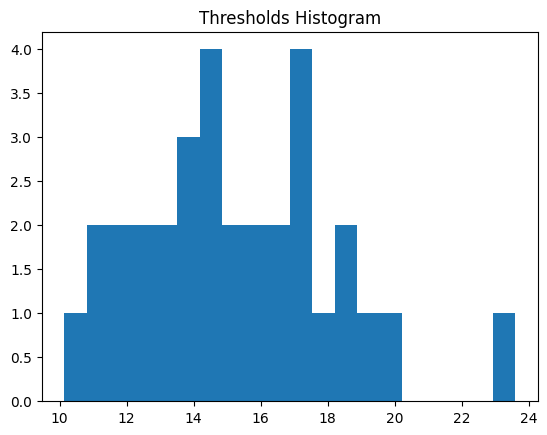

In [7]:
plt.hist(model_test.thresholds.numpy(), bins=20)
plt.title("Thresholds Histogram")

In [8]:
def plot_thresholds(*threshold_pairs: tuple[np.array, str]):
    x = np.arange(0, len(threshold_pairs[0][0]))
    for threshold_pair in threshold_pairs:
        threshold, label = threshold_pair
        plt.scatter(x, threshold, label=label, marker="o")
    plt.legend()
    plt.title("Thresholds evolution")
    plt.xlabel("Neuron index")
    plt.ylabel("Threshold value")

## Random uniform thresholds test U(0, 30)

In [38]:
def simulate_random_thresholds(generator: callable, num_simulations: int):
    train_accuracies = []
    val_accuracies = []

    for i in range(num_simulations):
        print("=" * 50 + f"\n\nTEST {i}\n\n" + "=" * 50)
        random_model = load_model(f"../checkpoints/{model_checkpoint_name}.pkl")
        random_model.thresholds = nn.Parameter(generator(model_test.thresholds.shape))

        plt.figure(figsize=(18, 5))

        plt.subplot(1, 3, 1)
        plt.title("Random Thresholds")
        plt.hist(random_model.thresholds.detach().numpy(), bins=20)

        plt.subplot(1, 3, 2)
        plt.title("Original Thresholds")
        plt.hist(model_test.thresholds.detach().numpy(), bins=20)

        metrics = eval_snn(random_model, train=True, visualize=False)
        plt.subplot(1, 3, 3)
        plot_thresholds((model_test.thresholds.detach().numpy(), 'original'), (random_model.thresholds.detach().numpy(), 'random'))
        plt.show()

        train_accuracies.append(metrics[0][0])
        val_accuracies.append(metrics[1][0])
    return train_accuracies, val_accuracies


TEST 0

Train metrics:
Accuracy: 0.57
Precision: 0.59
Recall: 0.57
F1 Score: 0.53

Validation metrics:
Accuracy: 0.56
Precision: 0.55
Recall: 0.56
F1 Score: 0.52


/Users/Razvan/CodeUni/dummy-snn/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


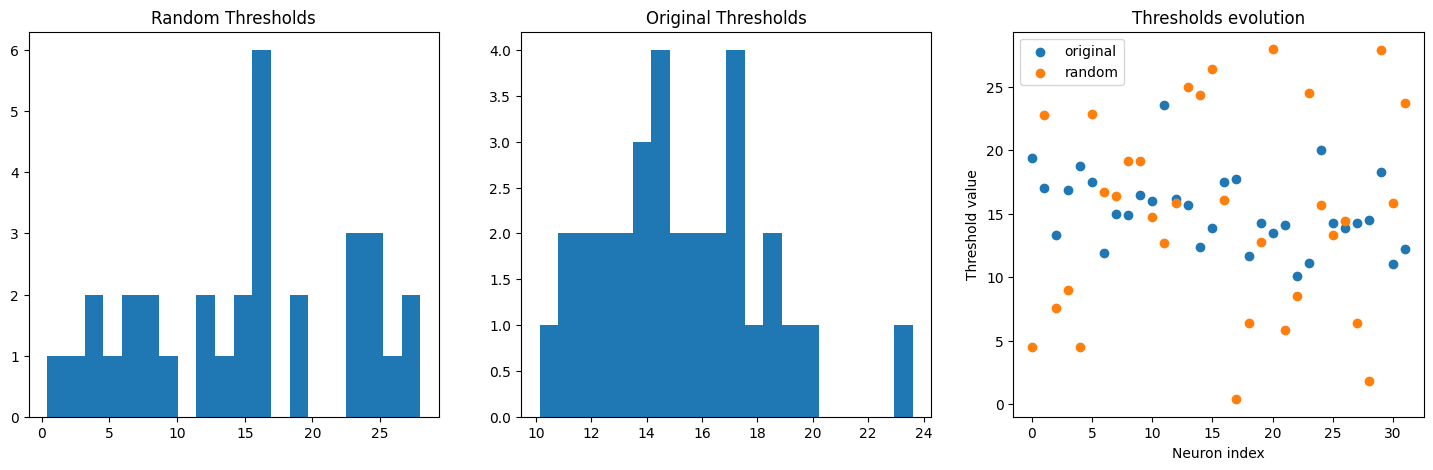


TEST 1

Train metrics:
Accuracy: 0.55
Precision: 0.60
Recall: 0.55
F1 Score: 0.53

Validation metrics:
Accuracy: 0.52
Precision: 0.56
Recall: 0.52
F1 Score: 0.51


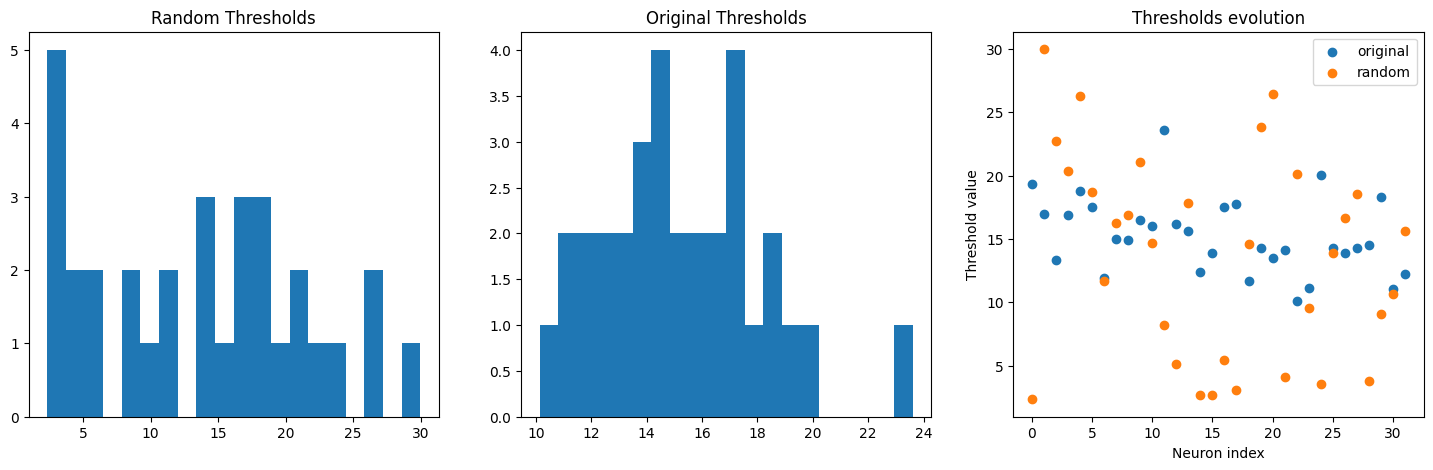


TEST 2

Train metrics:
Accuracy: 0.56
Precision: 0.61
Recall: 0.57
F1 Score: 0.52

Validation metrics:
Accuracy: 0.56
Precision: 0.68
Recall: 0.56
F1 Score: 0.52


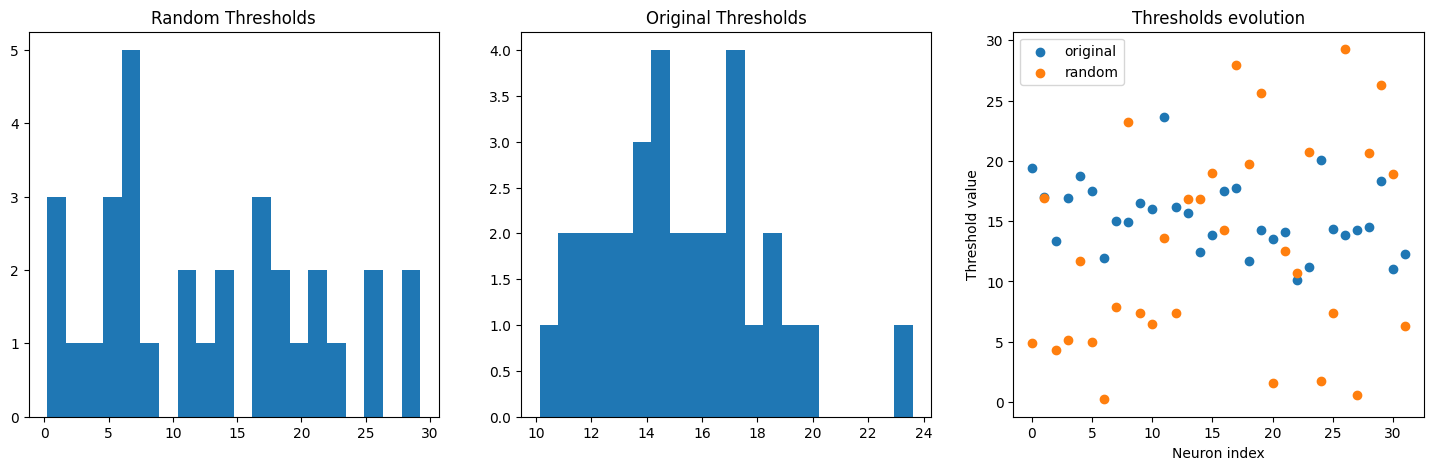


TEST 3

Train metrics:
Accuracy: 0.45
Precision: 0.53
Recall: 0.45
F1 Score: 0.37

Validation metrics:
Accuracy: 0.43
Precision: 0.54
Recall: 0.43
F1 Score: 0.37


/Users/Razvan/CodeUni/dummy-snn/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


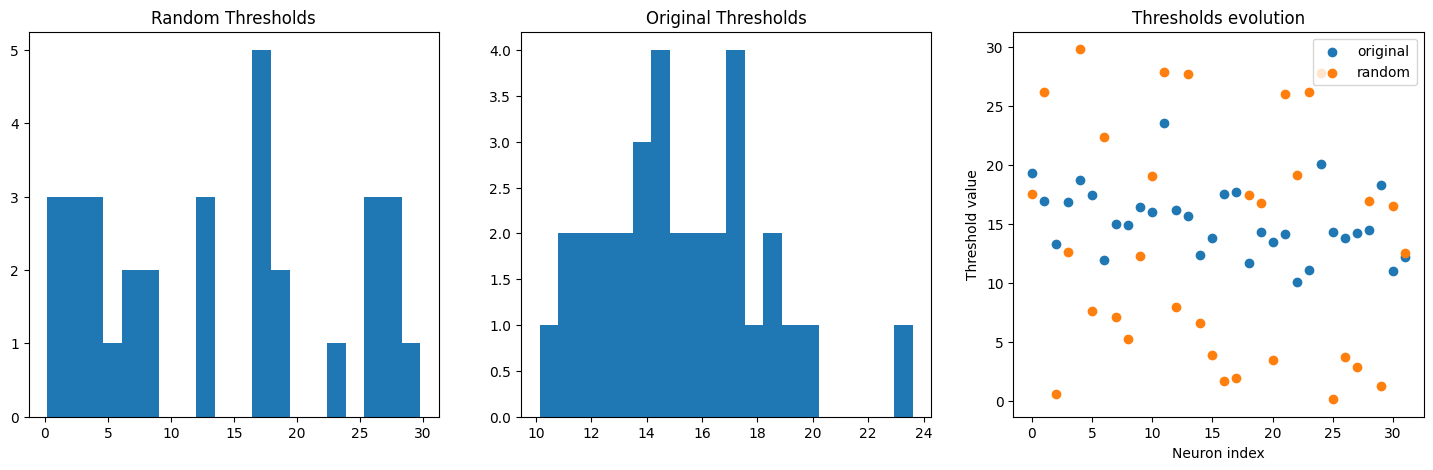


TEST 4

Train metrics:
Accuracy: 0.56
Precision: 0.58
Recall: 0.56
F1 Score: 0.53

Validation metrics:
Accuracy: 0.57
Precision: 0.62
Recall: 0.57
F1 Score: 0.54


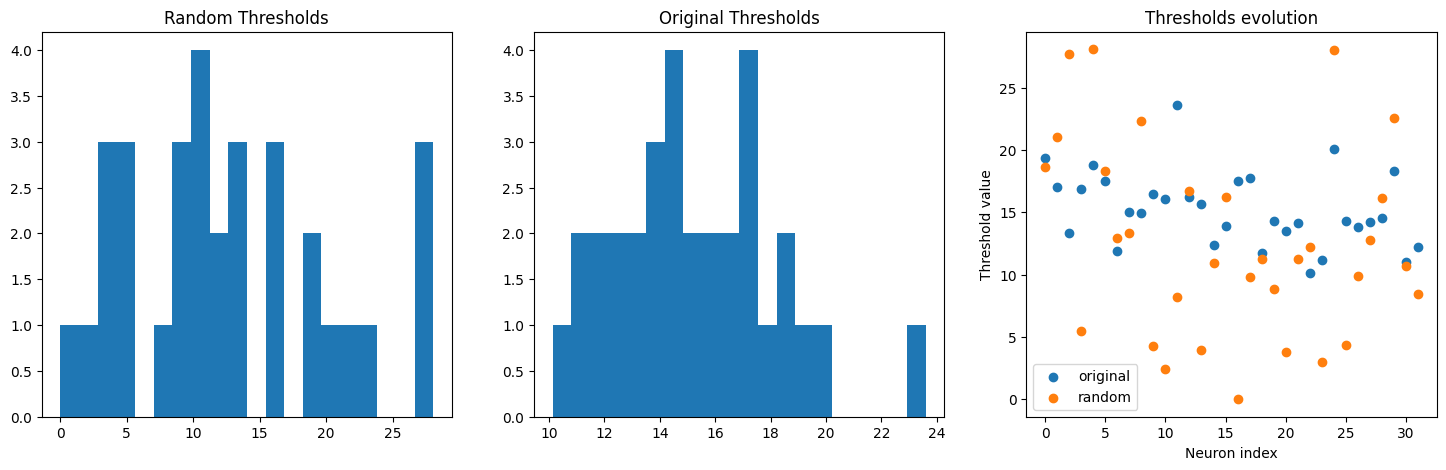


TEST 5

Train metrics:
Accuracy: 0.53
Precision: 0.58
Recall: 0.53
F1 Score: 0.49

Validation metrics:
Accuracy: 0.50
Precision: 0.58
Recall: 0.50
F1 Score: 0.44


/Users/Razvan/CodeUni/dummy-snn/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


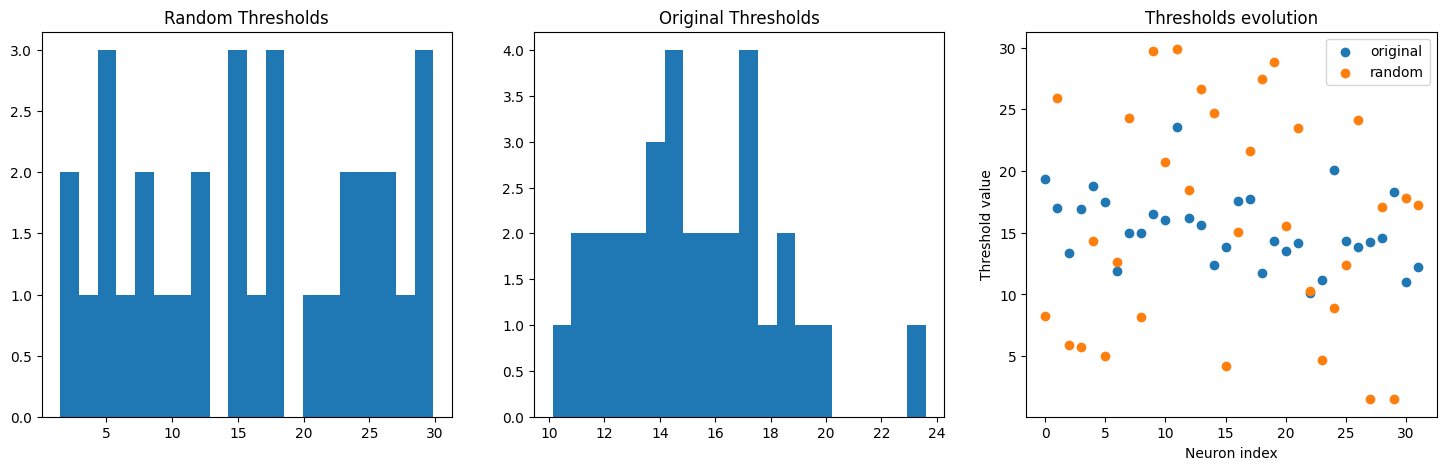


TEST 6

Train metrics:
Accuracy: 0.51
Precision: 0.52
Recall: 0.51
F1 Score: 0.45

Validation metrics:
Accuracy: 0.47
Precision: 0.52
Recall: 0.47
F1 Score: 0.42


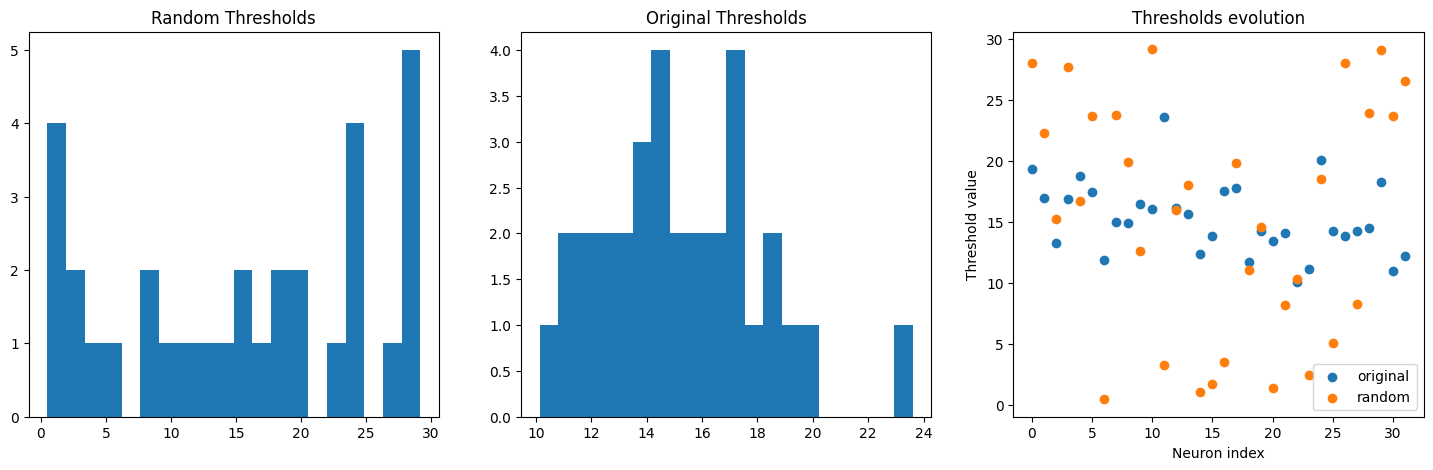


TEST 7

Train metrics:
Accuracy: 0.55
Precision: 0.64
Recall: 0.55
F1 Score: 0.50

Validation metrics:
Accuracy: 0.45
Precision: 0.57
Recall: 0.45
F1 Score: 0.40


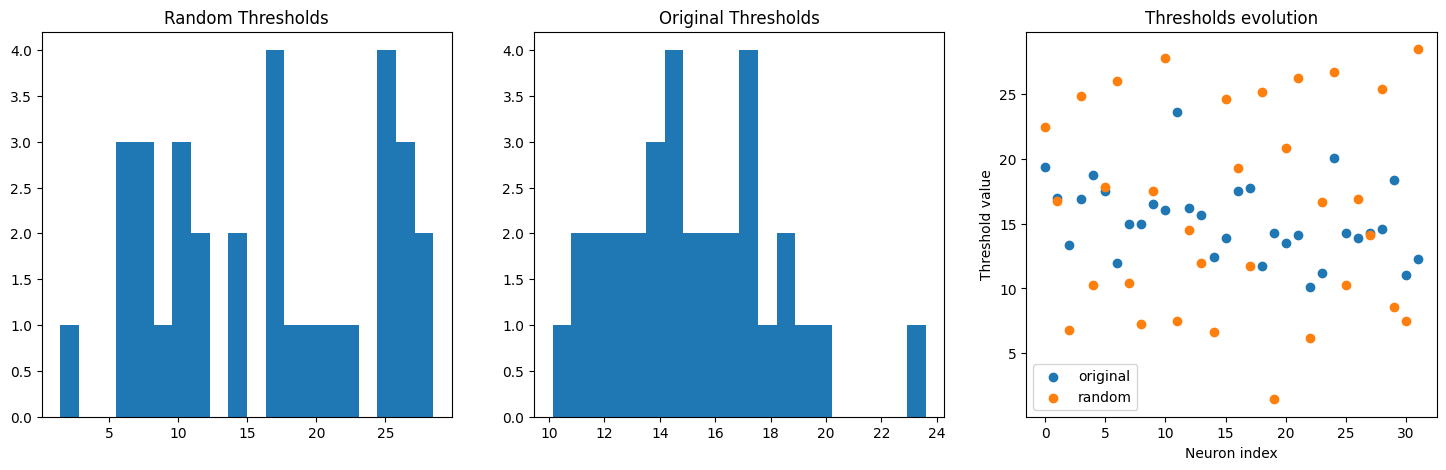


TEST 8

Train metrics:
Accuracy: 0.48
Precision: 0.48
Recall: 0.48
F1 Score: 0.43

Validation metrics:
Accuracy: 0.43
Precision: 0.47
Recall: 0.43
F1 Score: 0.37


/Users/Razvan/CodeUni/dummy-snn/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/Razvan/CodeUni/dummy-snn/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


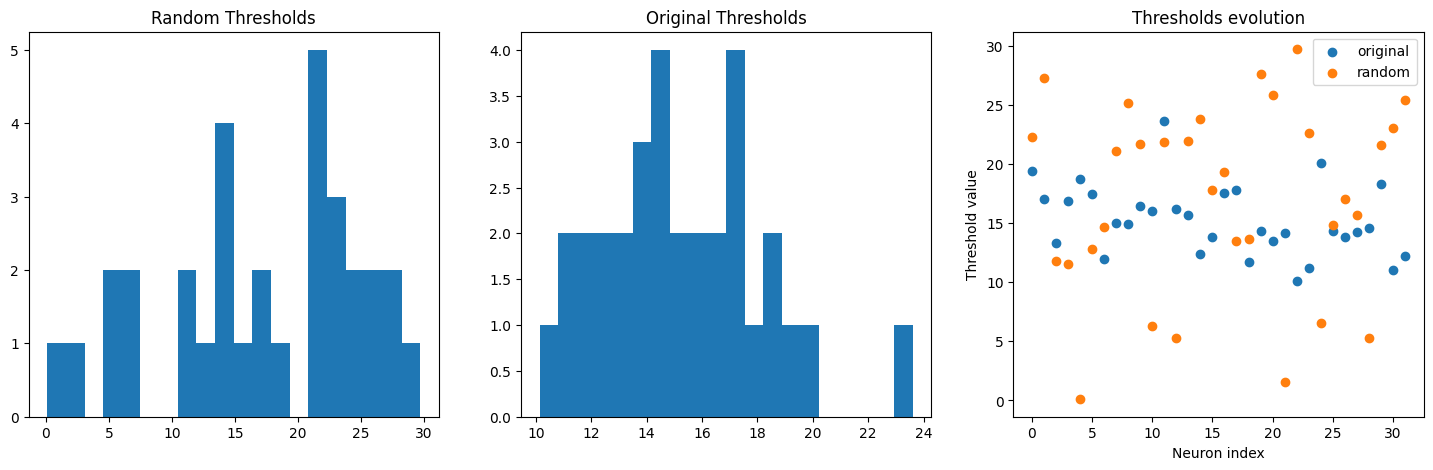


TEST 9

Train metrics:
Accuracy: 0.53
Precision: 0.55
Recall: 0.53
F1 Score: 0.49

Validation metrics:
Accuracy: 0.42
Precision: 0.46
Recall: 0.42
F1 Score: 0.37


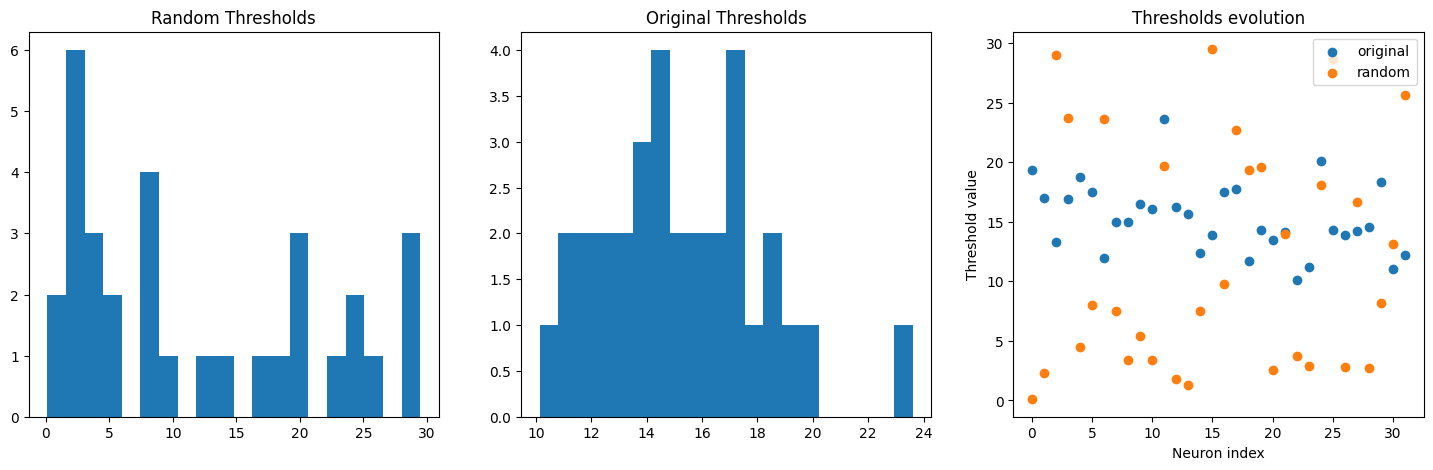

In [25]:
train_accuracies, val_accuracies = simulate_random_thresholds(lambda shape: torch.rand(shape) * 30, 10)

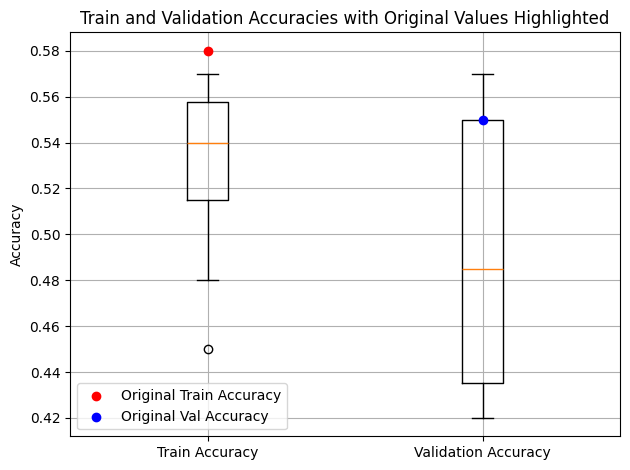

In [29]:
def plot_train_accuracies_vs_val_accuracies(train_accuracies, val_accuracies, base_train_accuracy, base_val_accuracy):
    fig, ax = plt.subplots()
    ax.boxplot([train_accuracies, val_accuracies], tick_labels=["Train Accuracy", "Validation Accuracy"])

    ax.scatter(1, base_train_accuracy, color='red', label='Original Train Accuracy', zorder=3)
    ax.scatter(2, base_val_accuracy, color='blue', label='Original Val Accuracy', zorder=3)

    ax.legend()
    ax.set_title("Train and Validation Accuracies with Original Values Highlighted")
    ax.set_ylabel("Accuracy")

    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_train_accuracies_vs_val_accuracies(train_accuracies, val_accuracies, 0.58, 0.55)

## Random normal thresholds test N(15, 2)


TEST 0

Train metrics:
Accuracy: 0.59
Precision: 0.65
Recall: 0.59
F1 Score: 0.56

Validation metrics:
Accuracy: 0.56
Precision: 0.59
Recall: 0.56
F1 Score: 0.53


/Users/Razvan/CodeUni/dummy-snn/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


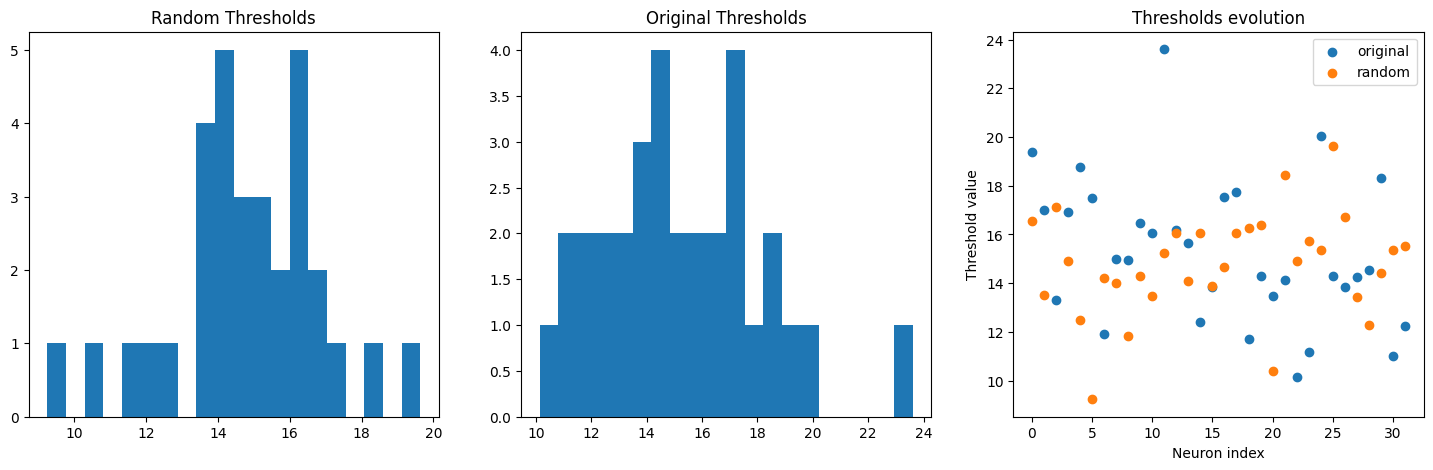


TEST 1

Train metrics:
Accuracy: 0.62
Precision: 0.67
Recall: 0.62
F1 Score: 0.60

Validation metrics:
Accuracy: 0.55
Precision: 0.66
Recall: 0.55
F1 Score: 0.53


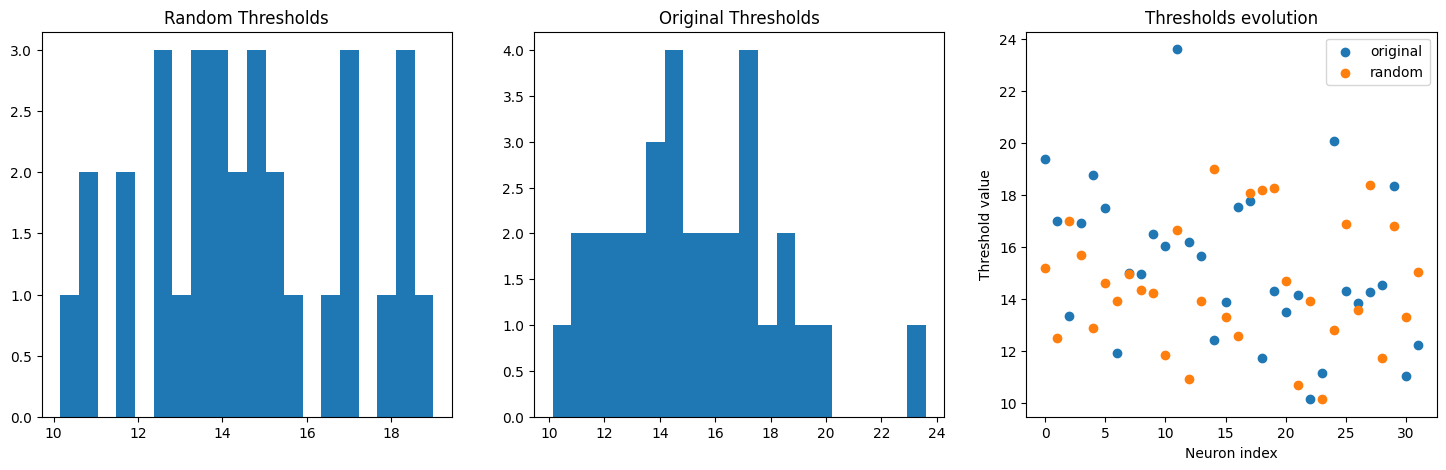


TEST 2

Train metrics:
Accuracy: 0.61
Precision: 0.64
Recall: 0.61
F1 Score: 0.57

Validation metrics:
Accuracy: 0.56
Precision: 0.66
Recall: 0.56
F1 Score: 0.54


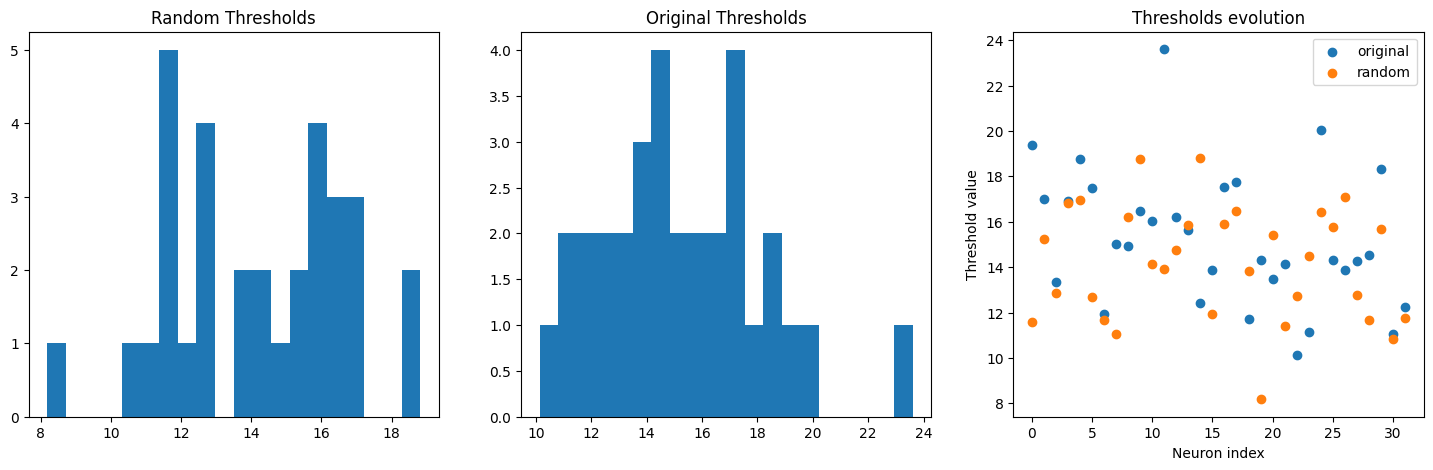


TEST 3

Train metrics:
Accuracy: 0.61
Precision: 0.64
Recall: 0.61
F1 Score: 0.59

Validation metrics:
Accuracy: 0.60
Precision: 0.67
Recall: 0.60
F1 Score: 0.59


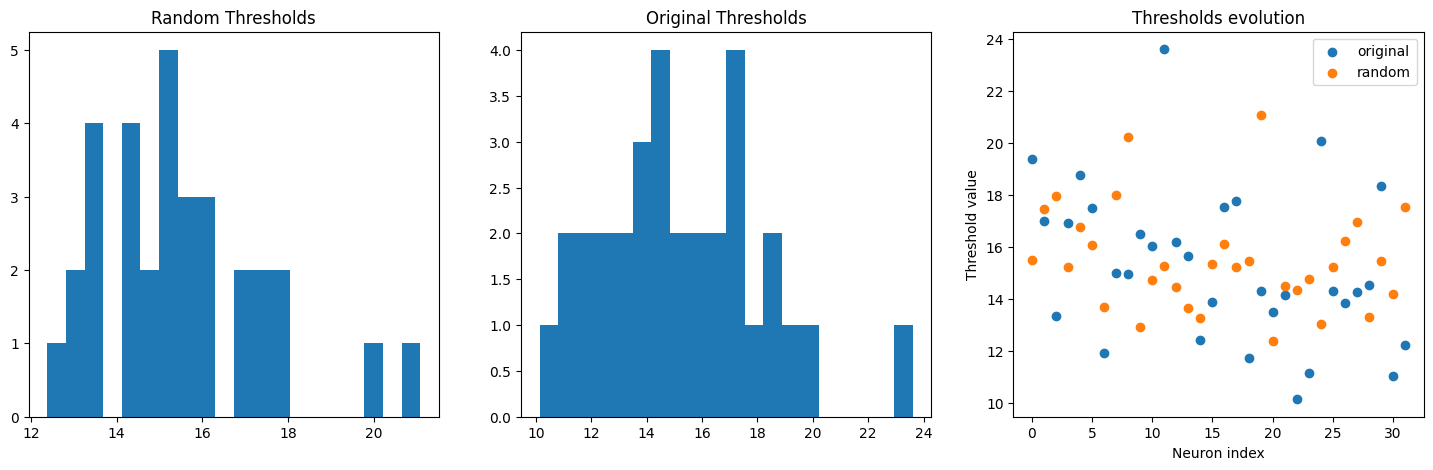


TEST 4

Train metrics:
Accuracy: 0.58
Precision: 0.61
Recall: 0.58
F1 Score: 0.54

Validation metrics:
Accuracy: 0.57
Precision: 0.65
Recall: 0.57
F1 Score: 0.56


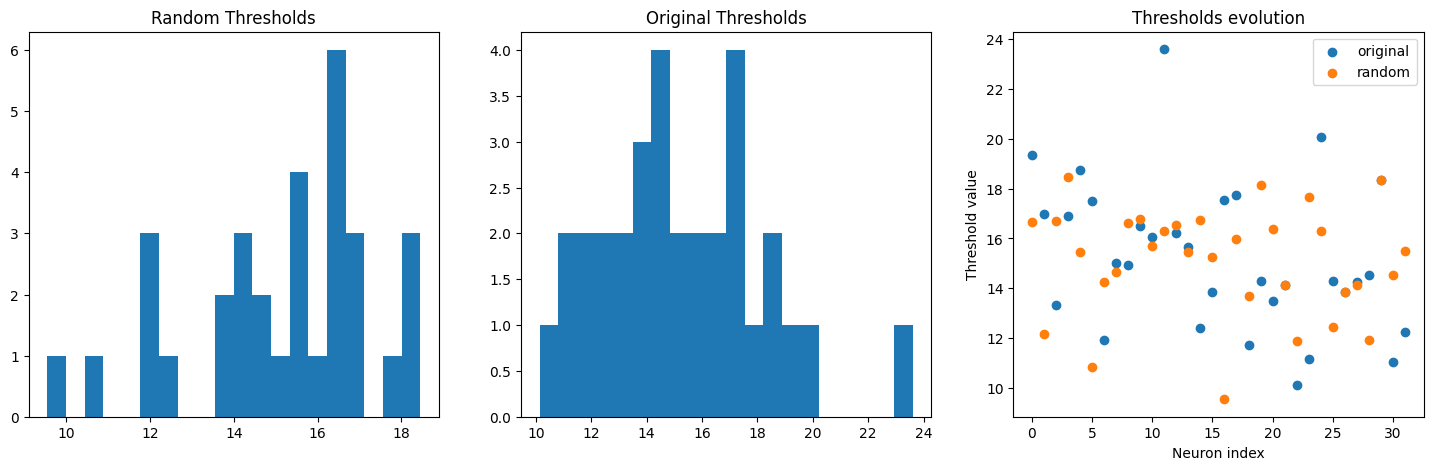


TEST 5

Train metrics:
Accuracy: 0.61
Precision: 0.65
Recall: 0.61
F1 Score: 0.58

Validation metrics:
Accuracy: 0.59
Precision: 0.72
Recall: 0.59
F1 Score: 0.59


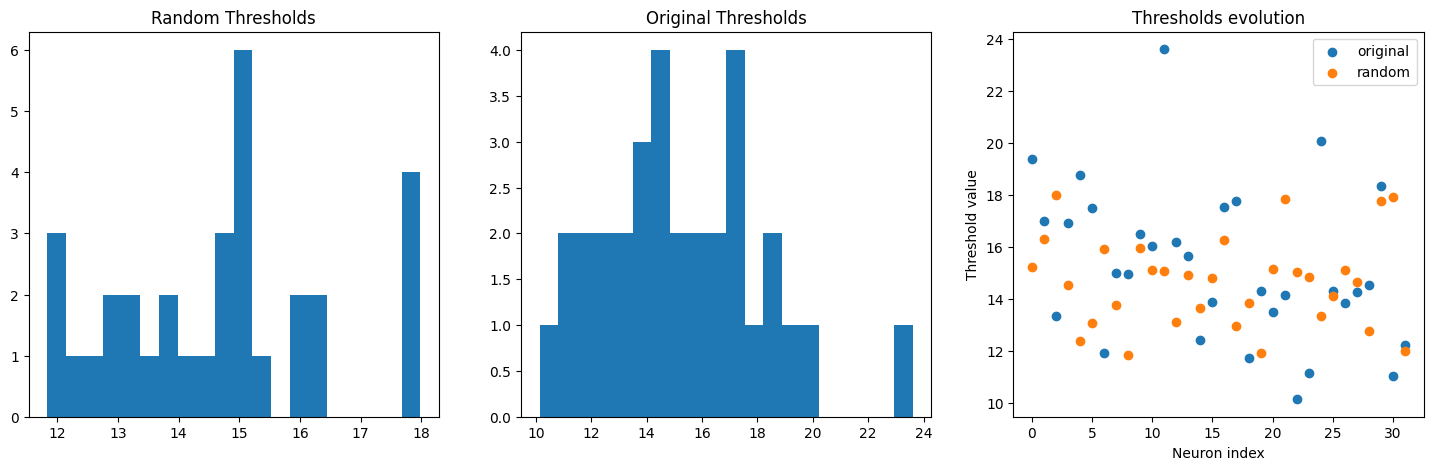


TEST 6

Train metrics:
Accuracy: 0.60
Precision: 0.65
Recall: 0.60
F1 Score: 0.58

Validation metrics:
Accuracy: 0.54
Precision: 0.61
Recall: 0.54
F1 Score: 0.52


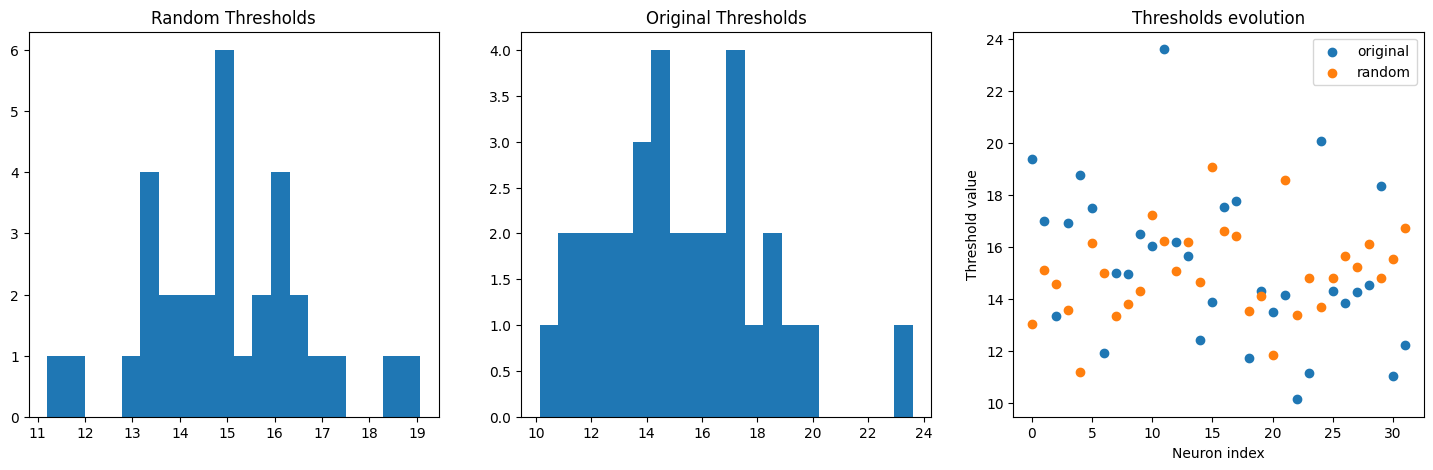


TEST 7

Train metrics:
Accuracy: 0.61
Precision: 0.68
Recall: 0.61
F1 Score: 0.58

Validation metrics:
Accuracy: 0.55
Precision: 0.64
Recall: 0.55
F1 Score: 0.52


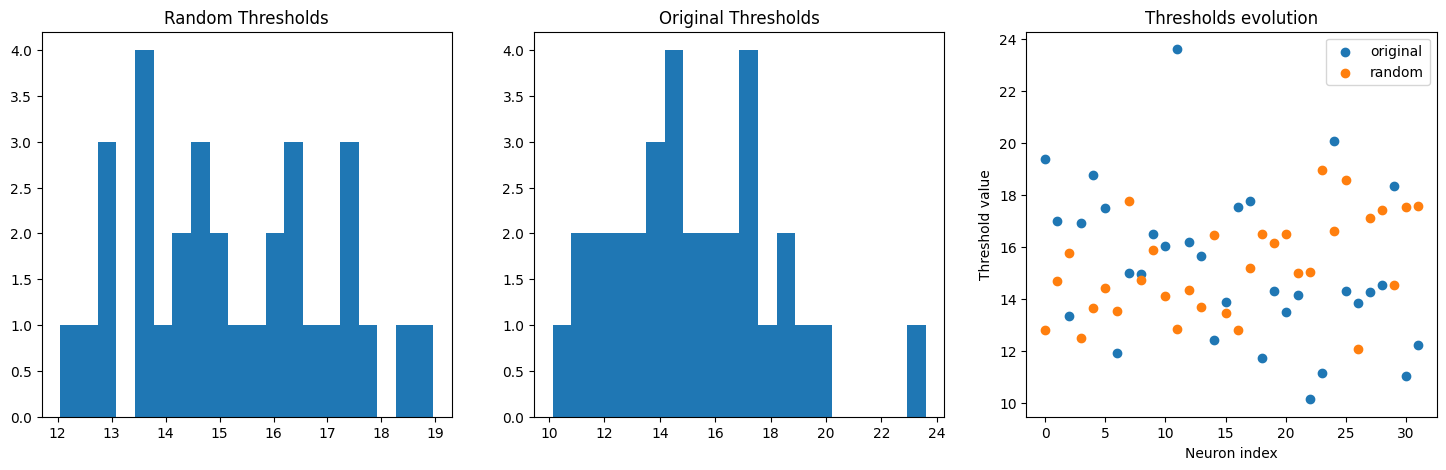


TEST 8

Train metrics:
Accuracy: 0.60
Precision: 0.63
Recall: 0.60
F1 Score: 0.57

Validation metrics:
Accuracy: 0.61
Precision: 0.70
Recall: 0.61
F1 Score: 0.60


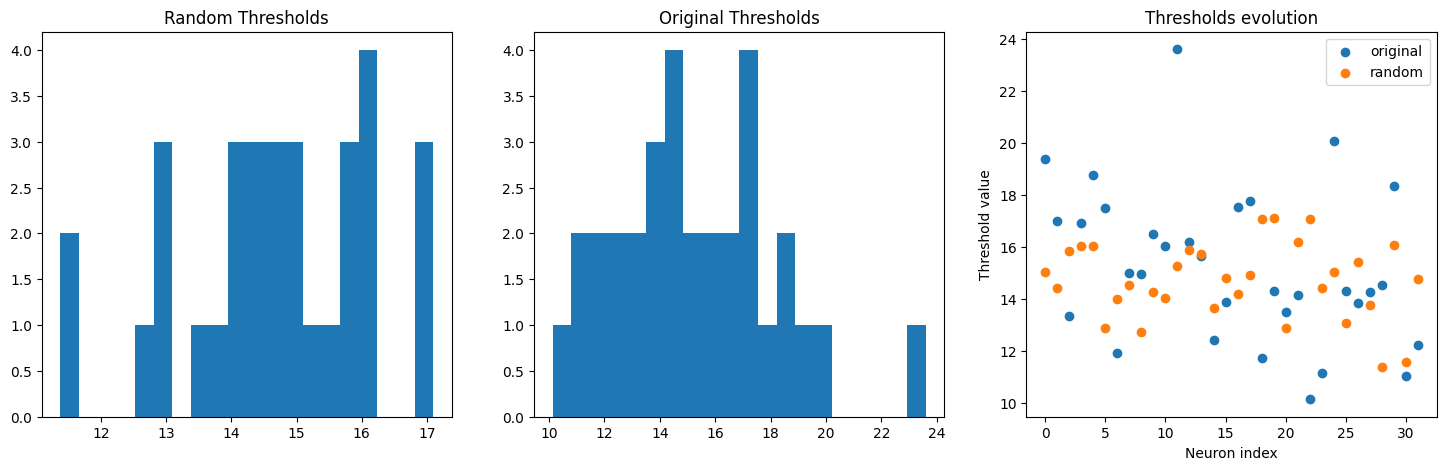


TEST 9

Train metrics:
Accuracy: 0.59
Precision: 0.65
Recall: 0.59
F1 Score: 0.57

Validation metrics:
Accuracy: 0.57
Precision: 0.68
Recall: 0.57
F1 Score: 0.55


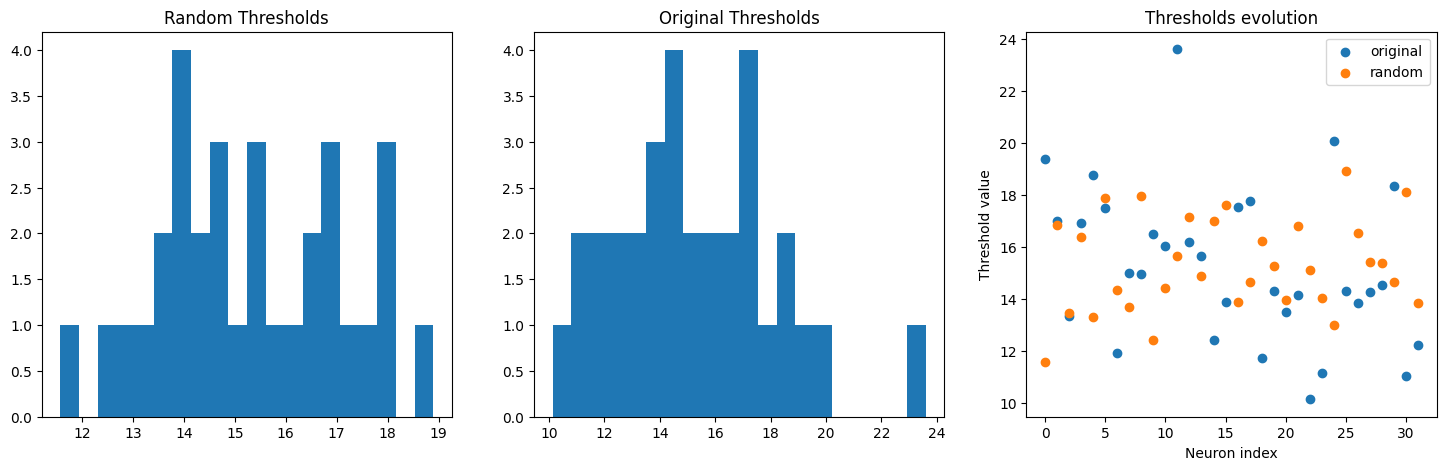

In [31]:
train_accuracies, val_accuracies = simulate_random_thresholds(lambda shape: torch.normal(mean=15, std=2, size=shape), 10)

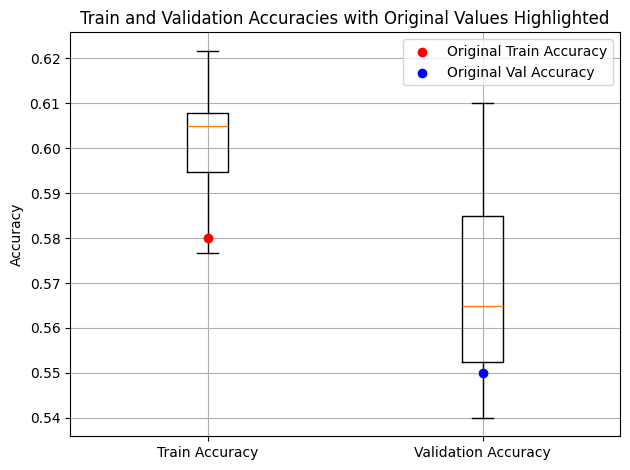

In [32]:
plot_train_accuracies_vs_val_accuracies(train_accuracies, val_accuracies, 0.58, 0.55)

## Fixed threshold: 15


TEST 0

Train metrics:
Accuracy: 0.62
Precision: 0.67
Recall: 0.62
F1 Score: 0.60

Validation metrics:
Accuracy: 0.58
Precision: 0.68
Recall: 0.58
F1 Score: 0.57


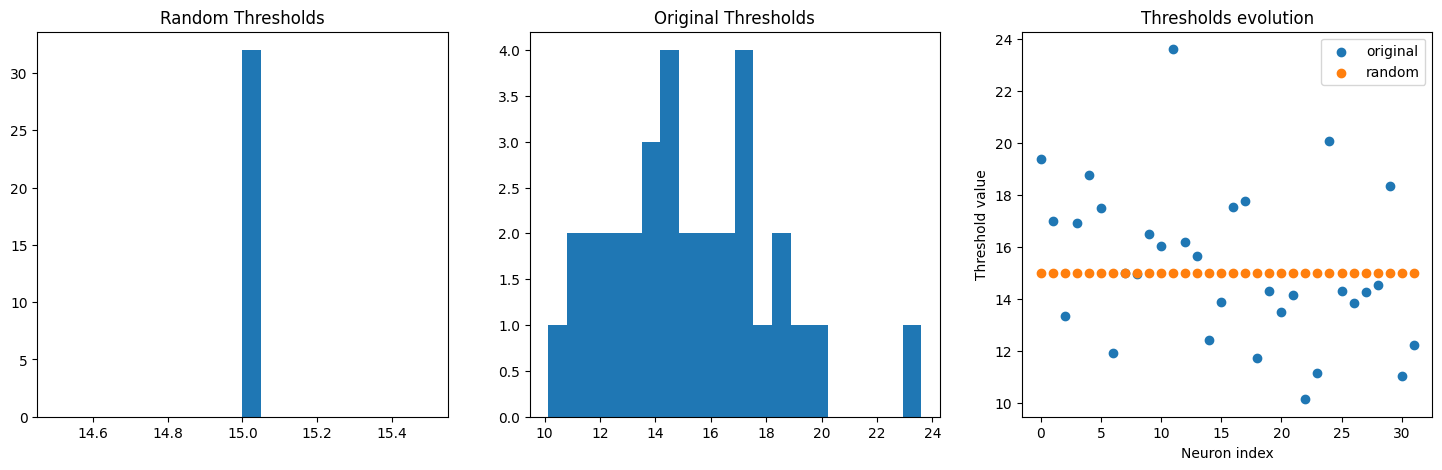

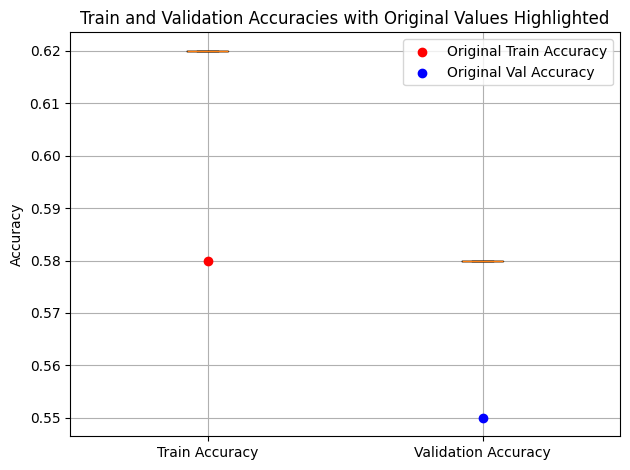

In [39]:
train_accuracies, val_accuracies = simulate_random_thresholds(lambda shape: torch.ones(shape) * 15, 1)
plot_train_accuracies_vs_val_accuracies(train_accuracies, val_accuracies, 0.58, 0.55)

## Random normal thresholds test N(15, 1)


TEST 0

Train metrics:
Accuracy: 0.62
Precision: 0.67
Recall: 0.62
F1 Score: 0.60

Validation metrics:
Accuracy: 0.59
Precision: 0.70
Recall: 0.59
F1 Score: 0.58


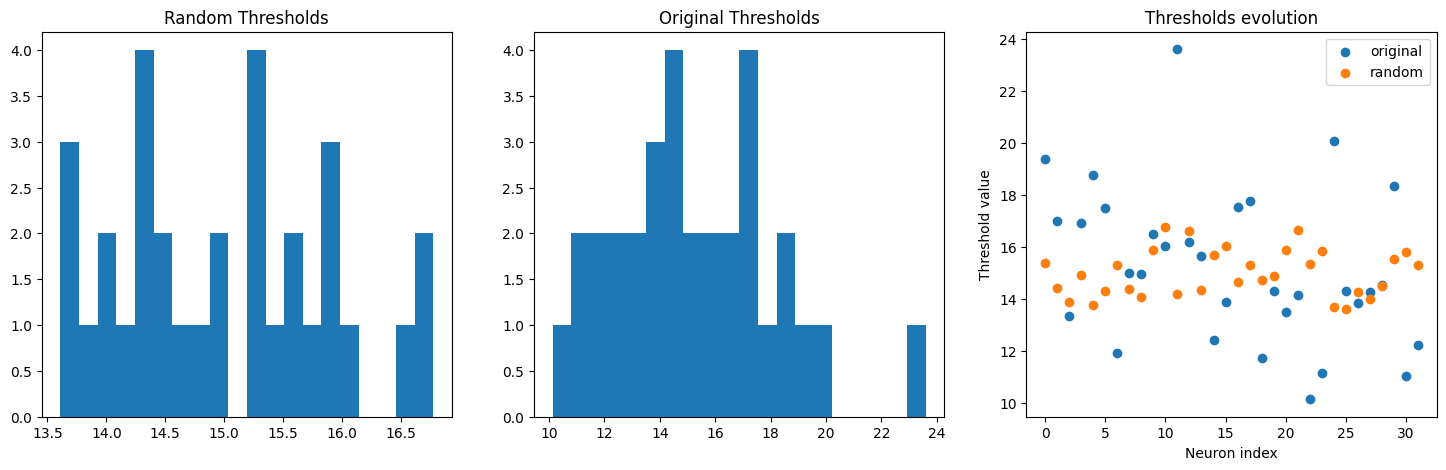


TEST 1

Train metrics:
Accuracy: 0.61
Precision: 0.65
Recall: 0.61
F1 Score: 0.59

Validation metrics:
Accuracy: 0.55
Precision: 0.63
Recall: 0.55
F1 Score: 0.54


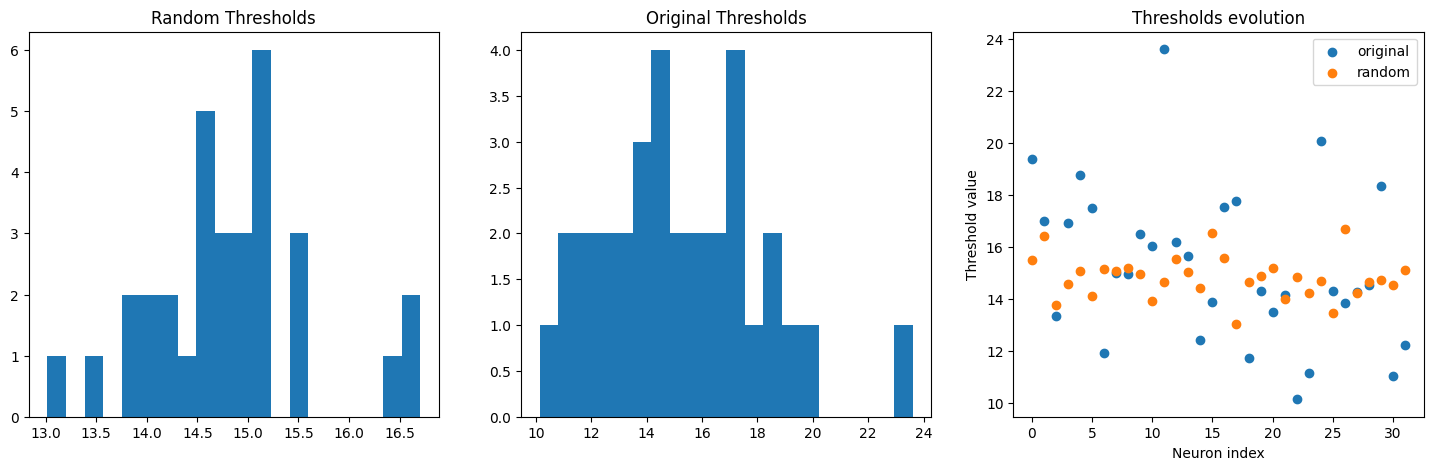


TEST 2

Train metrics:
Accuracy: 0.62
Precision: 0.67
Recall: 0.62
F1 Score: 0.60

Validation metrics:
Accuracy: 0.57
Precision: 0.69
Recall: 0.57
F1 Score: 0.56


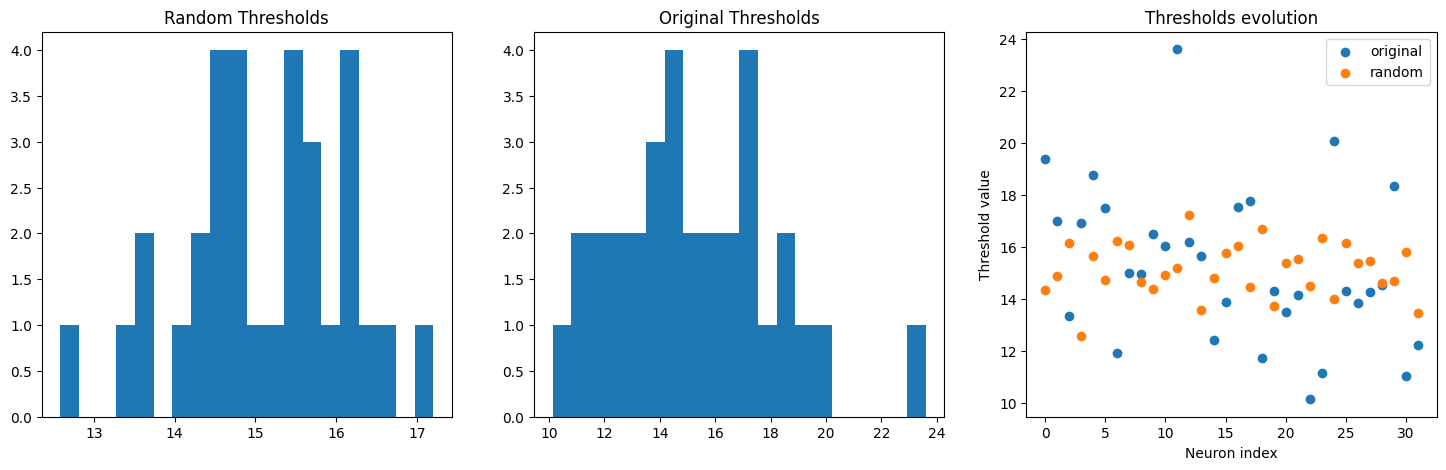


TEST 3

Train metrics:
Accuracy: 0.62
Precision: 0.67
Recall: 0.62
F1 Score: 0.60

Validation metrics:
Accuracy: 0.60
Precision: 0.69
Recall: 0.60
F1 Score: 0.58


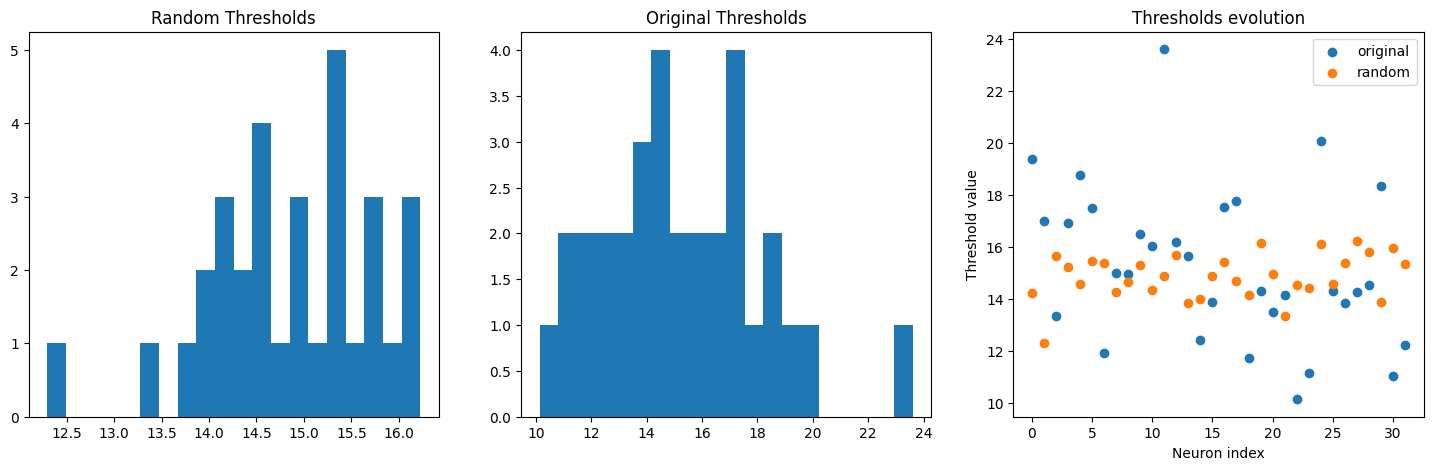


TEST 4

Train metrics:
Accuracy: 0.60
Precision: 0.64
Recall: 0.60
F1 Score: 0.57

Validation metrics:
Accuracy: 0.60
Precision: 0.67
Recall: 0.60
F1 Score: 0.59


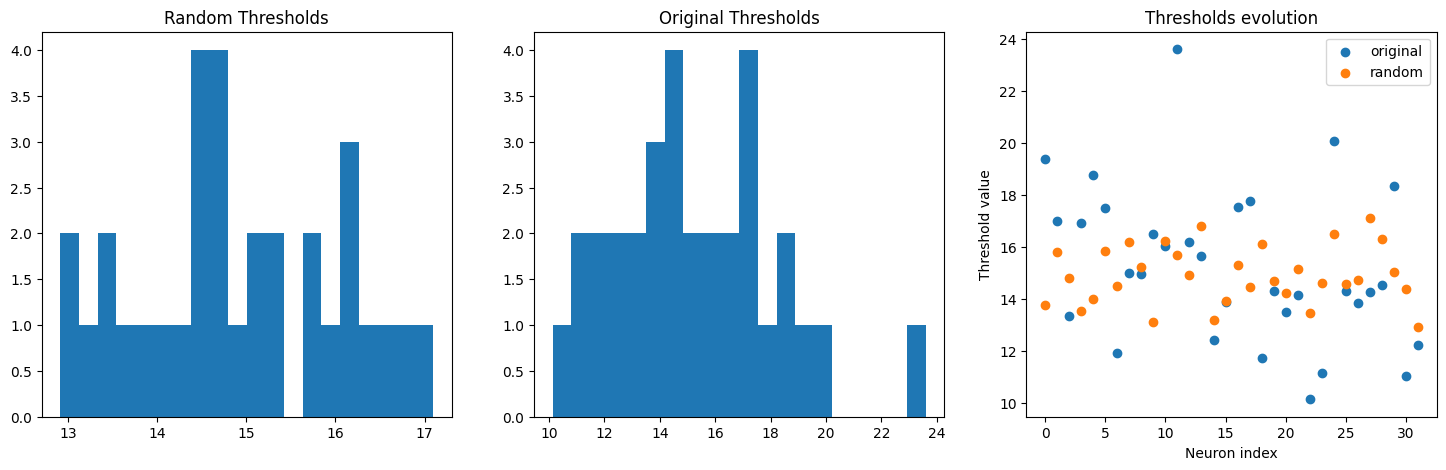


TEST 5

Train metrics:
Accuracy: 0.63
Precision: 0.67
Recall: 0.63
F1 Score: 0.61

Validation metrics:
Accuracy: 0.60
Precision: 0.68
Recall: 0.60
F1 Score: 0.60


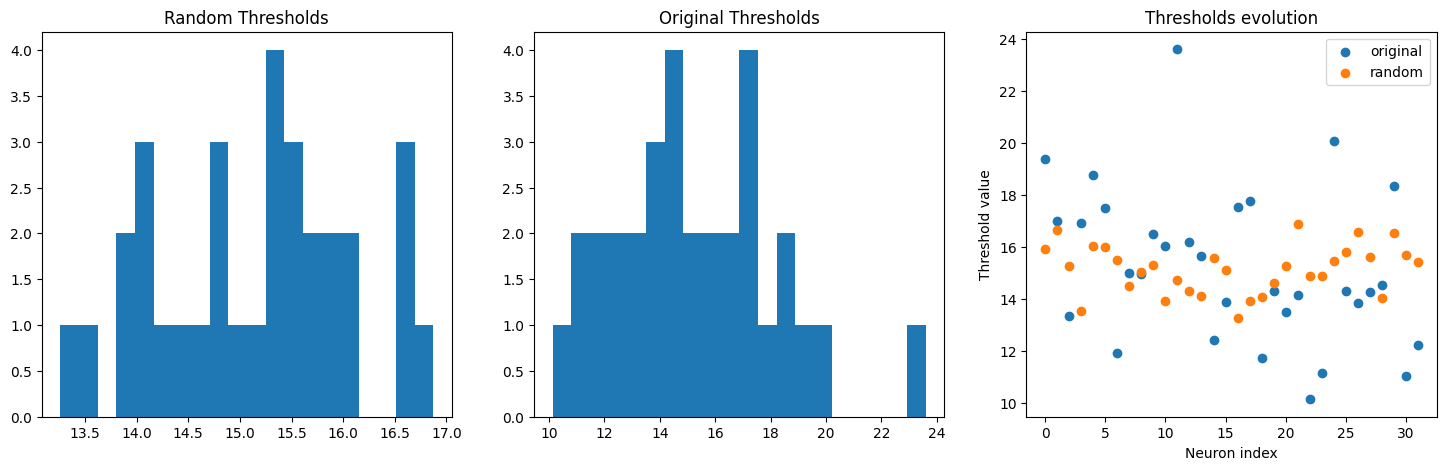


TEST 6

Train metrics:
Accuracy: 0.61
Precision: 0.66
Recall: 0.61
F1 Score: 0.59

Validation metrics:
Accuracy: 0.56
Precision: 0.65
Recall: 0.56
F1 Score: 0.54


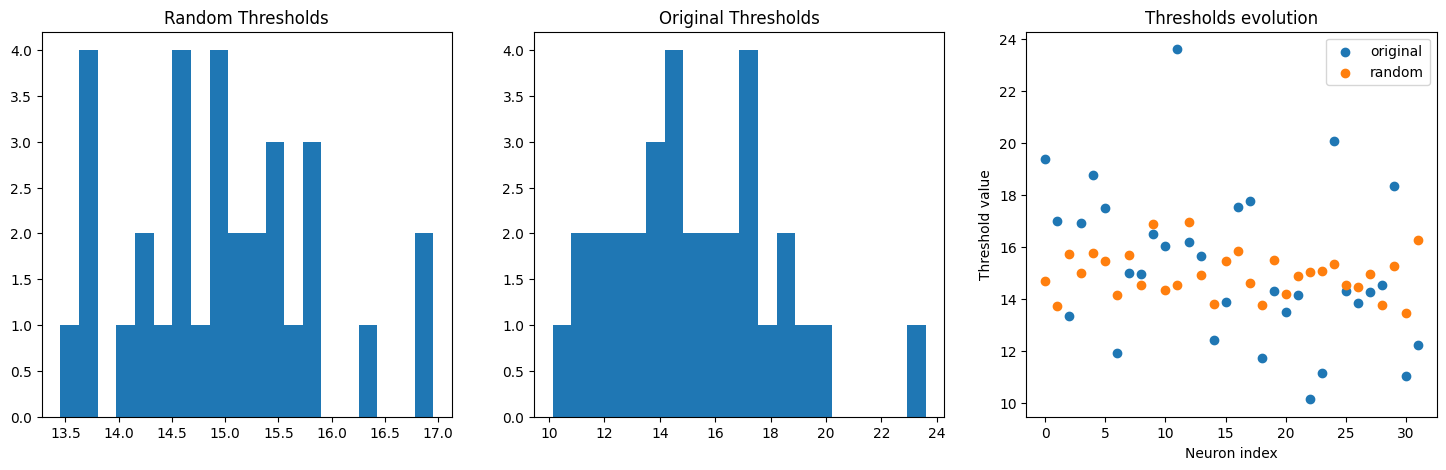


TEST 7

Train metrics:
Accuracy: 0.62
Precision: 0.68
Recall: 0.62
F1 Score: 0.60

Validation metrics:
Accuracy: 0.61
Precision: 0.70
Recall: 0.61
F1 Score: 0.59


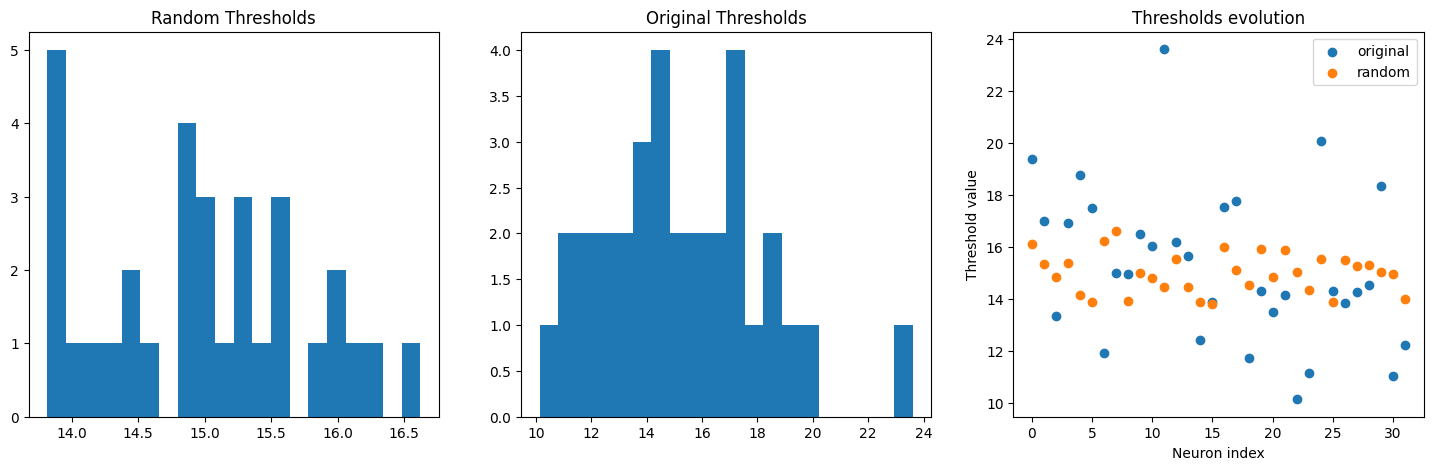


TEST 8

Train metrics:
Accuracy: 0.60
Precision: 0.64
Recall: 0.60
F1 Score: 0.58

Validation metrics:
Accuracy: 0.59
Precision: 0.67
Recall: 0.59
F1 Score: 0.58


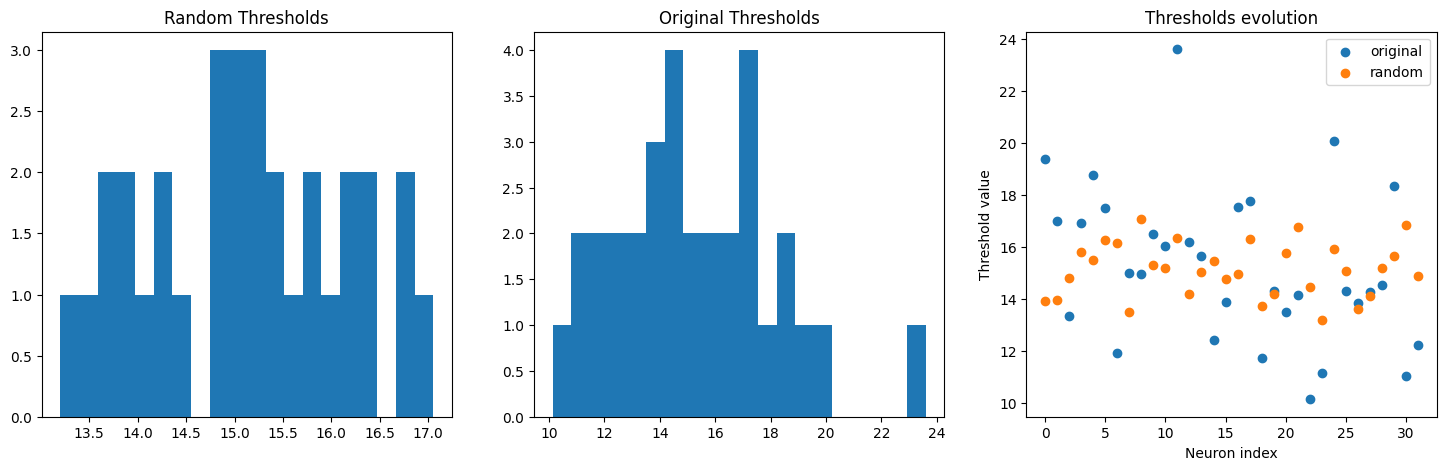


TEST 9

Train metrics:
Accuracy: 0.61
Precision: 0.64
Recall: 0.61
F1 Score: 0.58

Validation metrics:
Accuracy: 0.58
Precision: 0.64
Recall: 0.58
F1 Score: 0.57


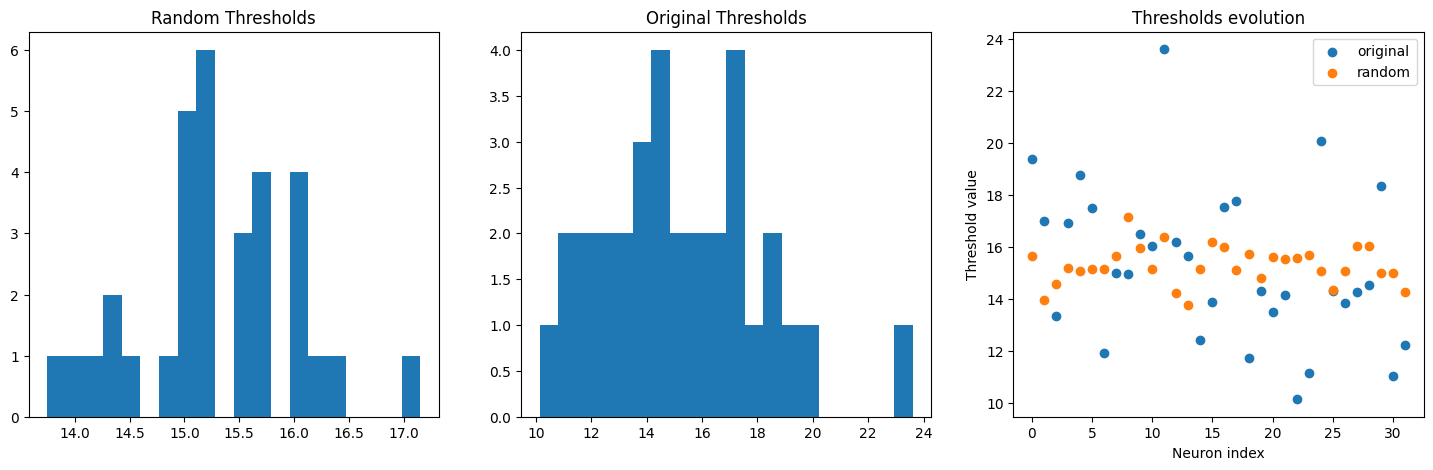

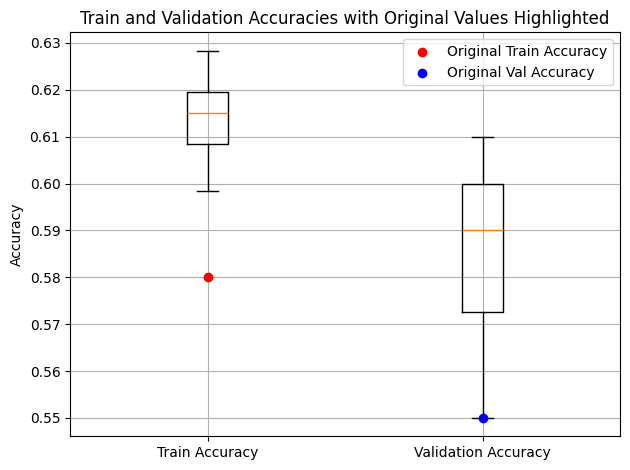

In [41]:
train_accuracies, val_accuracies = simulate_random_thresholds(lambda shape: torch.normal(mean=15, std=1, size=shape), 10)
plot_train_accuracies_vs_val_accuracies(train_accuracies, val_accuracies, 0.58, 0.55)

## Random normal thresholds test U(14, 16)


TEST 0

Train metrics:
Accuracy: 0.61
Precision: 0.65
Recall: 0.61
F1 Score: 0.58

Validation metrics:
Accuracy: 0.60
Precision: 0.68
Recall: 0.60
F1 Score: 0.58


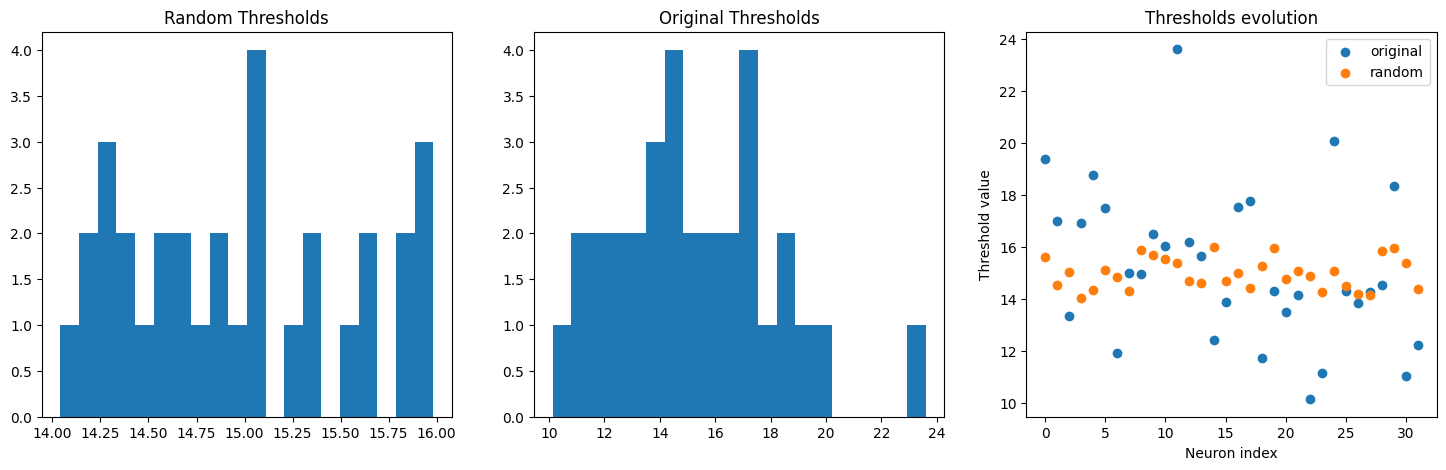


TEST 1

Train metrics:
Accuracy: 0.61
Precision: 0.65
Recall: 0.61
F1 Score: 0.58

Validation metrics:
Accuracy: 0.63
Precision: 0.75
Recall: 0.63
F1 Score: 0.62


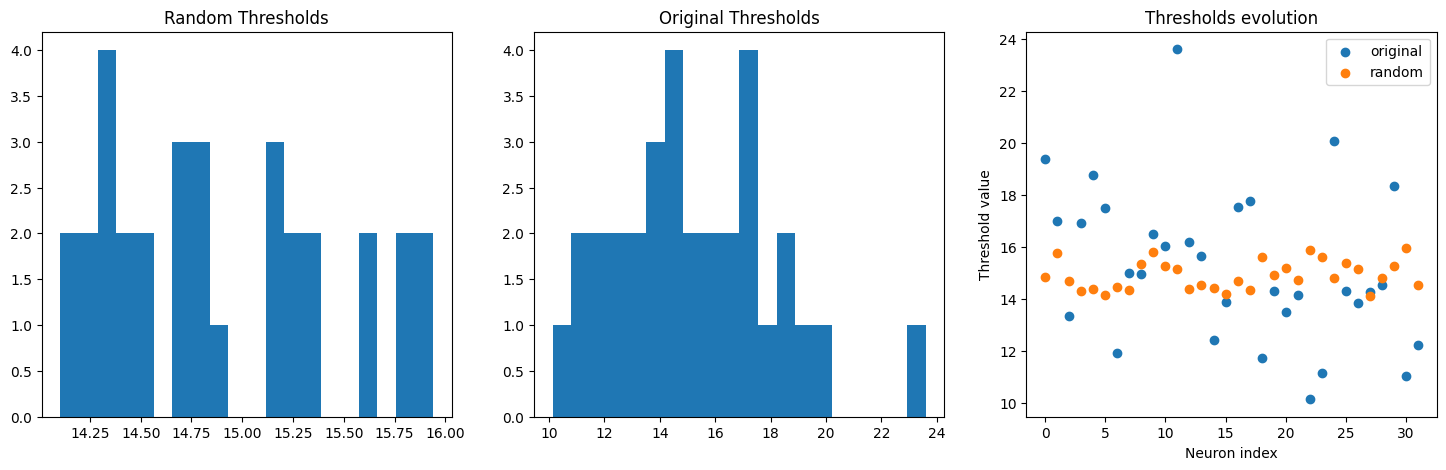


TEST 2

Train metrics:
Accuracy: 0.62
Precision: 0.67
Recall: 0.62
F1 Score: 0.61

Validation metrics:
Accuracy: 0.56
Precision: 0.64
Recall: 0.56
F1 Score: 0.54


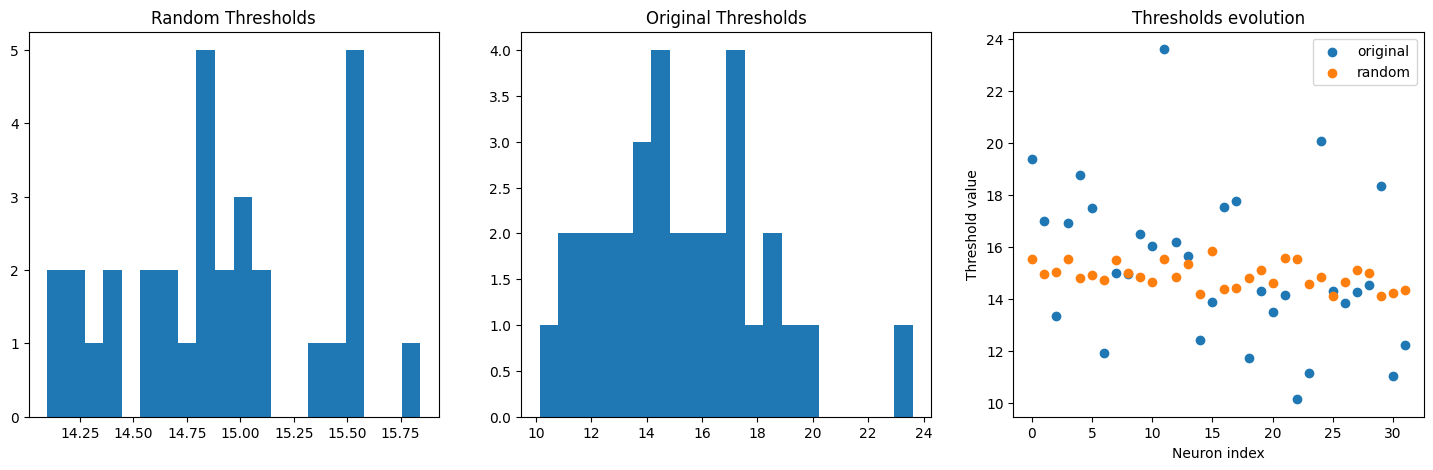


TEST 3

Train metrics:
Accuracy: 0.61
Precision: 0.66
Recall: 0.61
F1 Score: 0.59

Validation metrics:
Accuracy: 0.57
Precision: 0.65
Recall: 0.57
F1 Score: 0.55


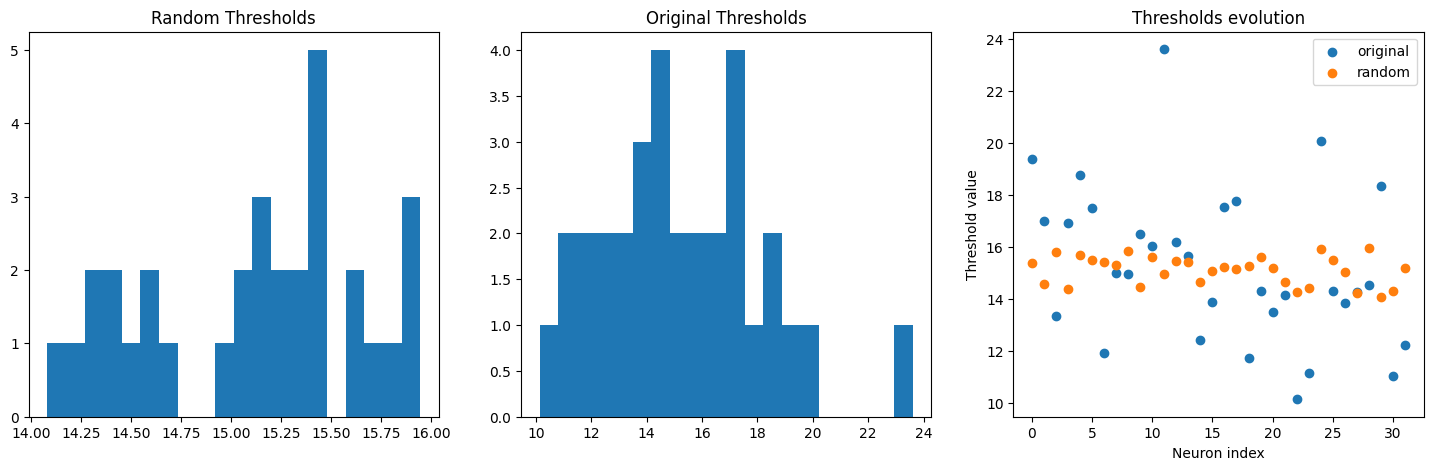


TEST 4

Train metrics:
Accuracy: 0.61
Precision: 0.65
Recall: 0.61
F1 Score: 0.59

Validation metrics:
Accuracy: 0.58
Precision: 0.68
Recall: 0.58
F1 Score: 0.57


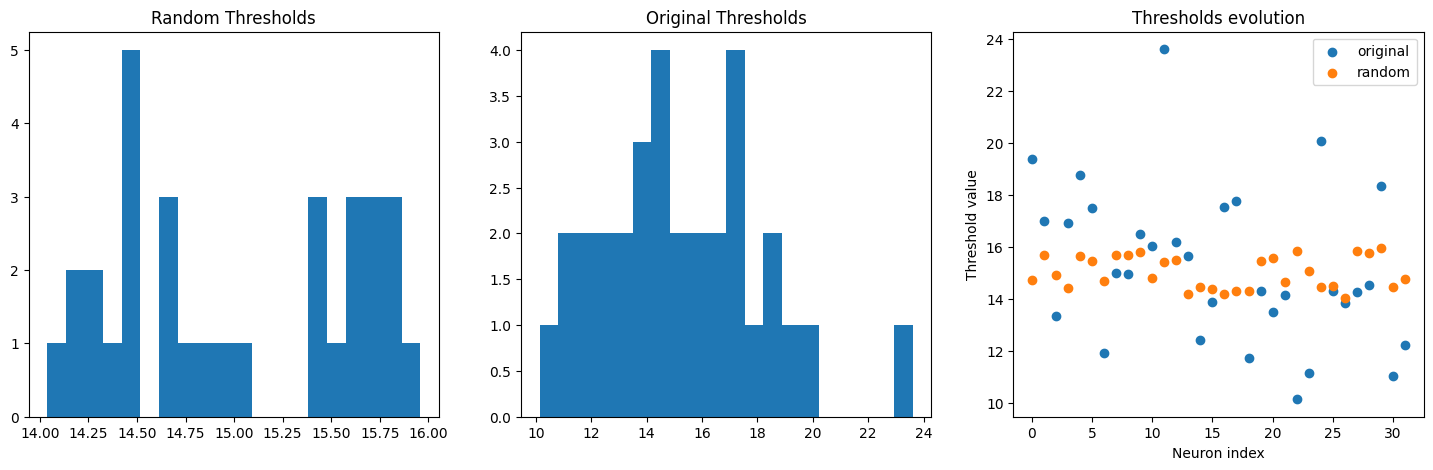


TEST 5

Train metrics:
Accuracy: 0.61
Precision: 0.65
Recall: 0.61
F1 Score: 0.59

Validation metrics:
Accuracy: 0.62
Precision: 0.75
Recall: 0.62
F1 Score: 0.62


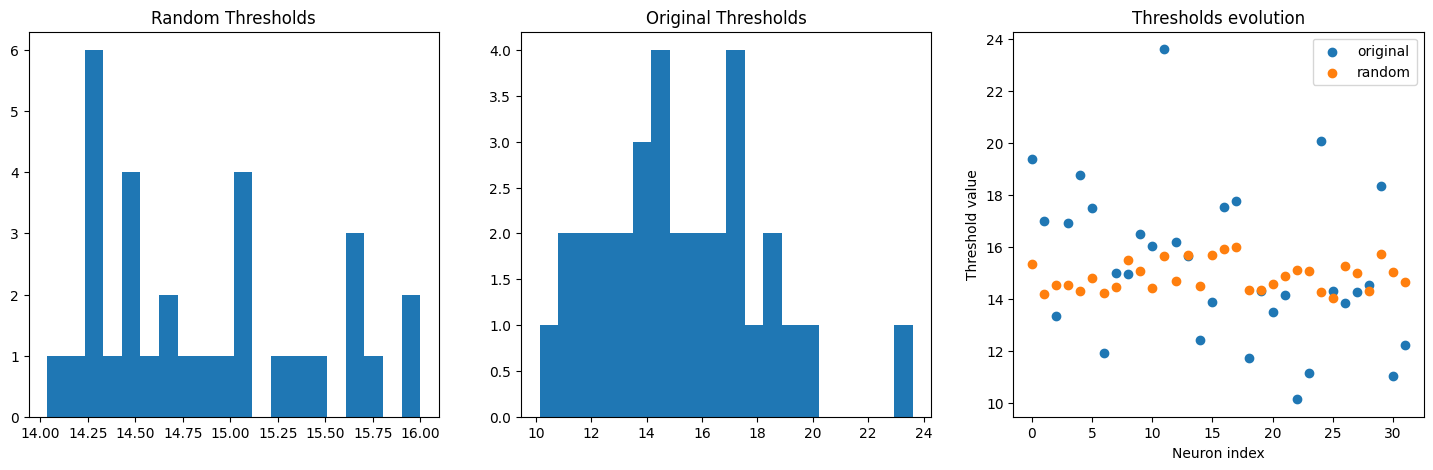


TEST 6

Train metrics:
Accuracy: 0.62
Precision: 0.65
Recall: 0.62
F1 Score: 0.59

Validation metrics:
Accuracy: 0.58
Precision: 0.67
Recall: 0.58
F1 Score: 0.57


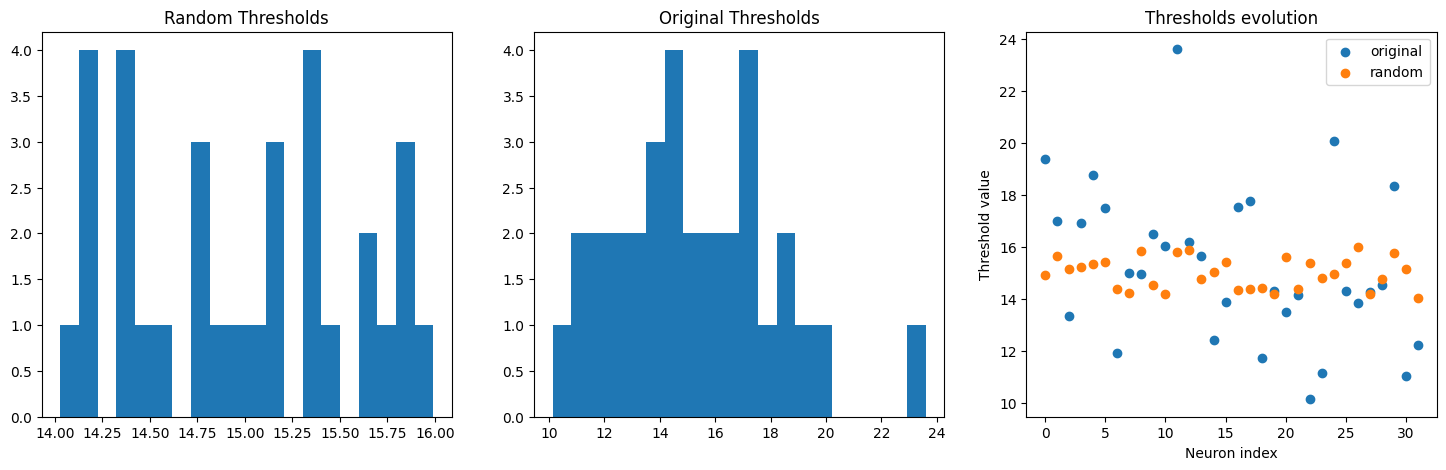


TEST 7

Train metrics:
Accuracy: 0.60
Precision: 0.66
Recall: 0.61
F1 Score: 0.59

Validation metrics:
Accuracy: 0.55
Precision: 0.67
Recall: 0.55
F1 Score: 0.54


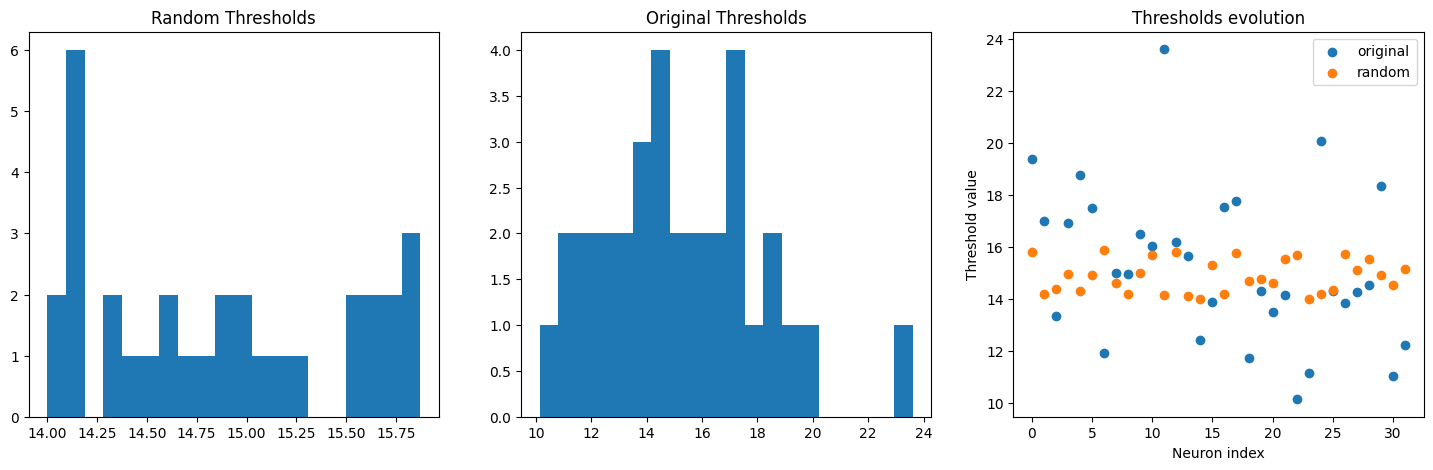


TEST 8

Train metrics:
Accuracy: 0.61
Precision: 0.64
Recall: 0.61
F1 Score: 0.59

Validation metrics:
Accuracy: 0.60
Precision: 0.69
Recall: 0.60
F1 Score: 0.58


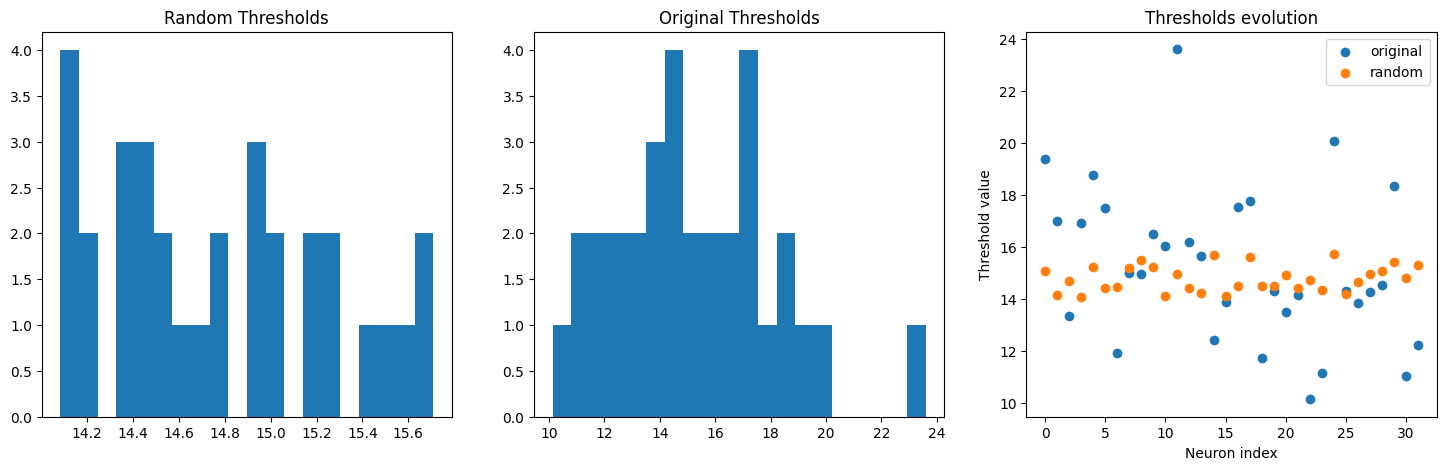


TEST 9

Train metrics:
Accuracy: 0.61
Precision: 0.66
Recall: 0.61
F1 Score: 0.59

Validation metrics:
Accuracy: 0.56
Precision: 0.63
Recall: 0.56
F1 Score: 0.54


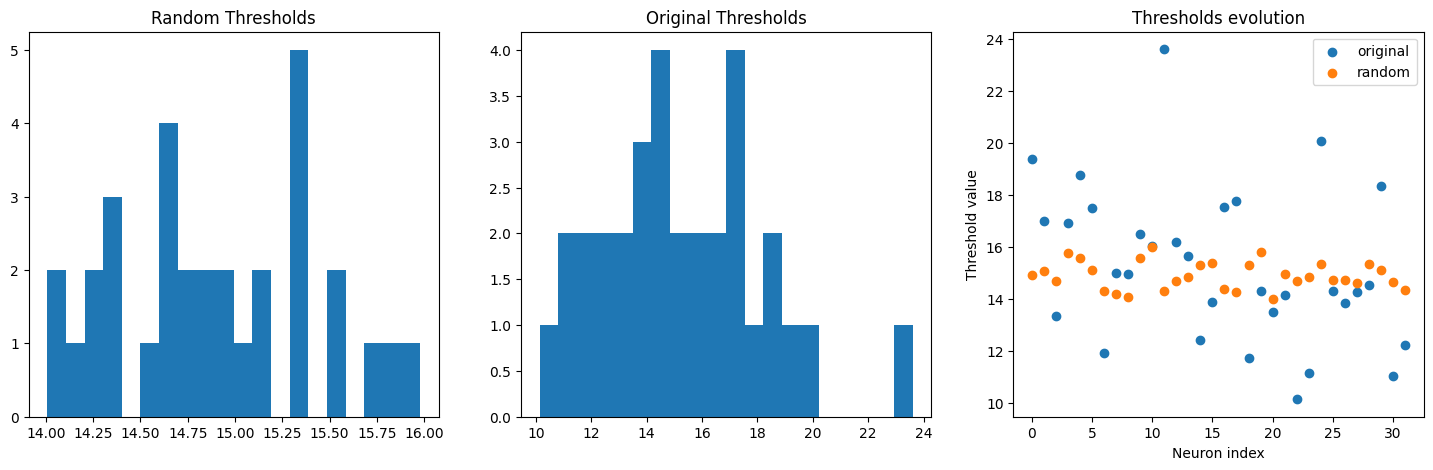

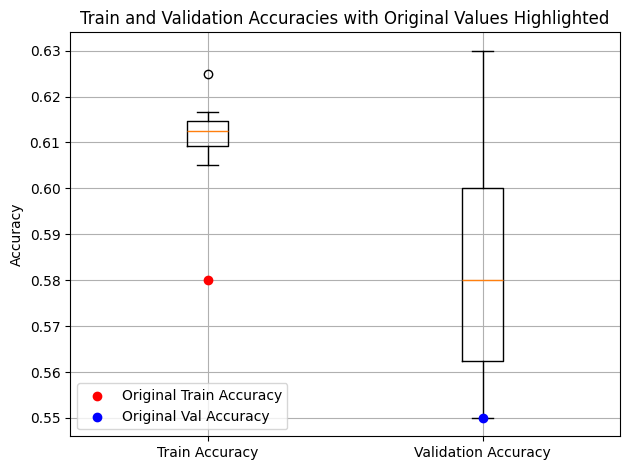

In [42]:
train_accuracies, val_accuracies = simulate_random_thresholds(lambda shape: torch.rand(shape) * 2 + 14, 10)
plot_train_accuracies_vs_val_accuracies(train_accuracies, val_accuracies, 0.58, 0.55)

## Random normal thresholds test N(15, 0.5)


TEST 0

Train metrics:
Accuracy: 0.62
Precision: 0.66
Recall: 0.62
F1 Score: 0.59

Validation metrics:
Accuracy: 0.61
Precision: 0.72
Recall: 0.61
F1 Score: 0.61


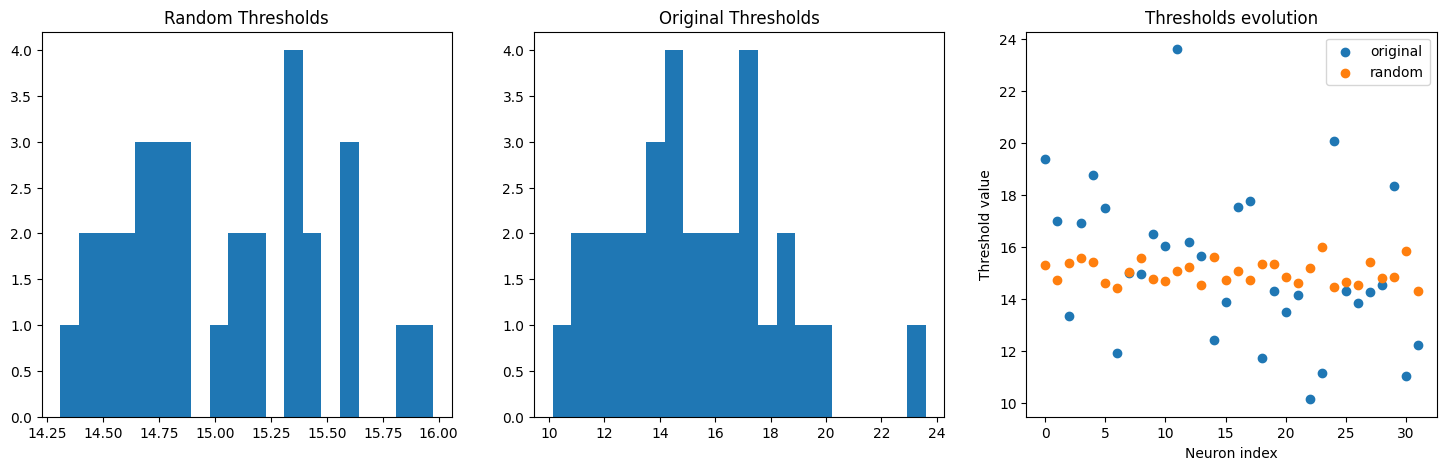


TEST 1

Train metrics:
Accuracy: 0.62
Precision: 0.66
Recall: 0.62
F1 Score: 0.60

Validation metrics:
Accuracy: 0.58
Precision: 0.68
Recall: 0.58
F1 Score: 0.56


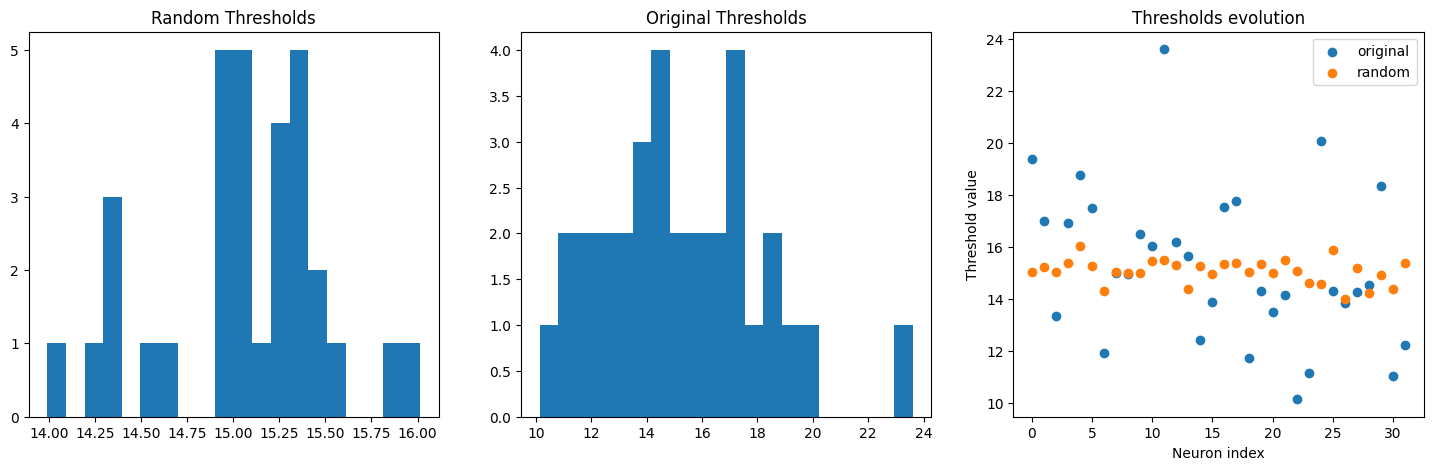


TEST 2

Train metrics:
Accuracy: 0.61
Precision: 0.66
Recall: 0.61
F1 Score: 0.59

Validation metrics:
Accuracy: 0.59
Precision: 0.69
Recall: 0.59
F1 Score: 0.58


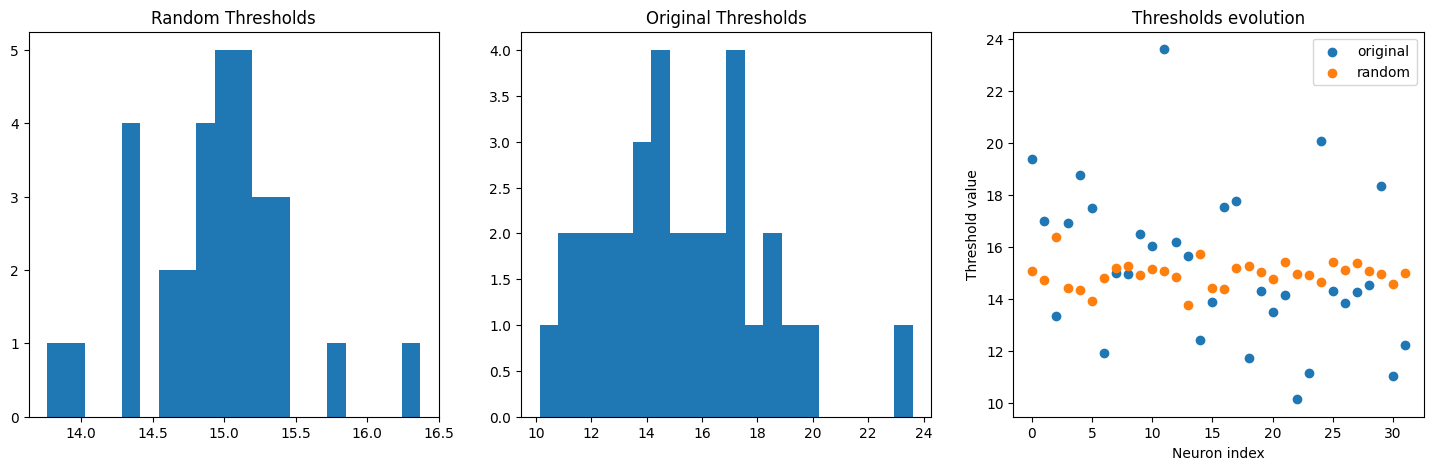


TEST 3

Train metrics:
Accuracy: 0.61
Precision: 0.65
Recall: 0.61
F1 Score: 0.59

Validation metrics:
Accuracy: 0.60
Precision: 0.69
Recall: 0.60
F1 Score: 0.58


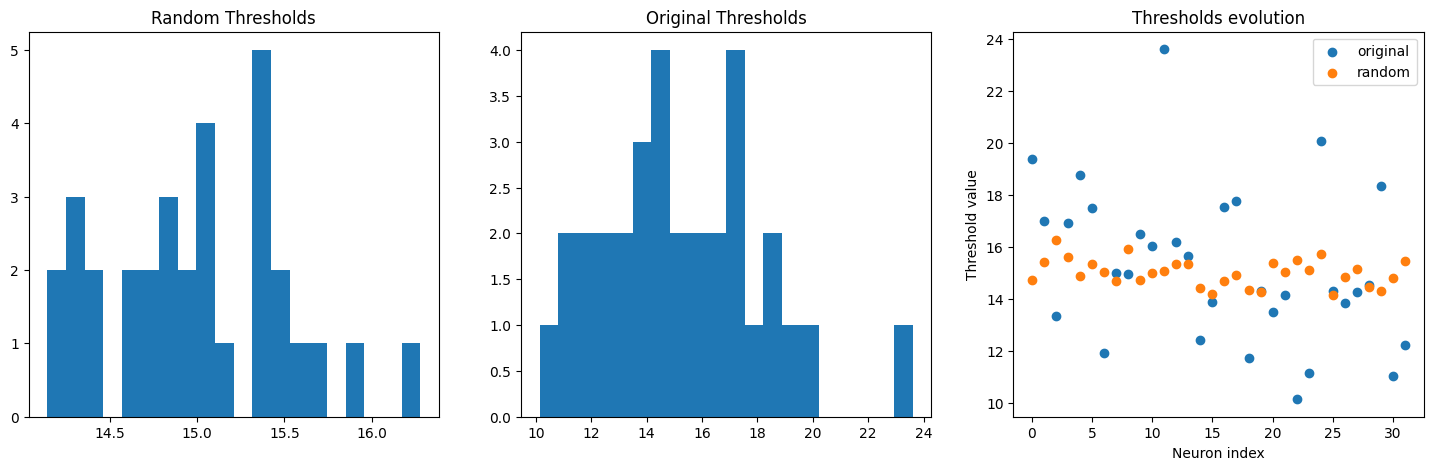


TEST 4

Train metrics:
Accuracy: 0.61
Precision: 0.65
Recall: 0.61
F1 Score: 0.58

Validation metrics:
Accuracy: 0.59
Precision: 0.70
Recall: 0.59
F1 Score: 0.58


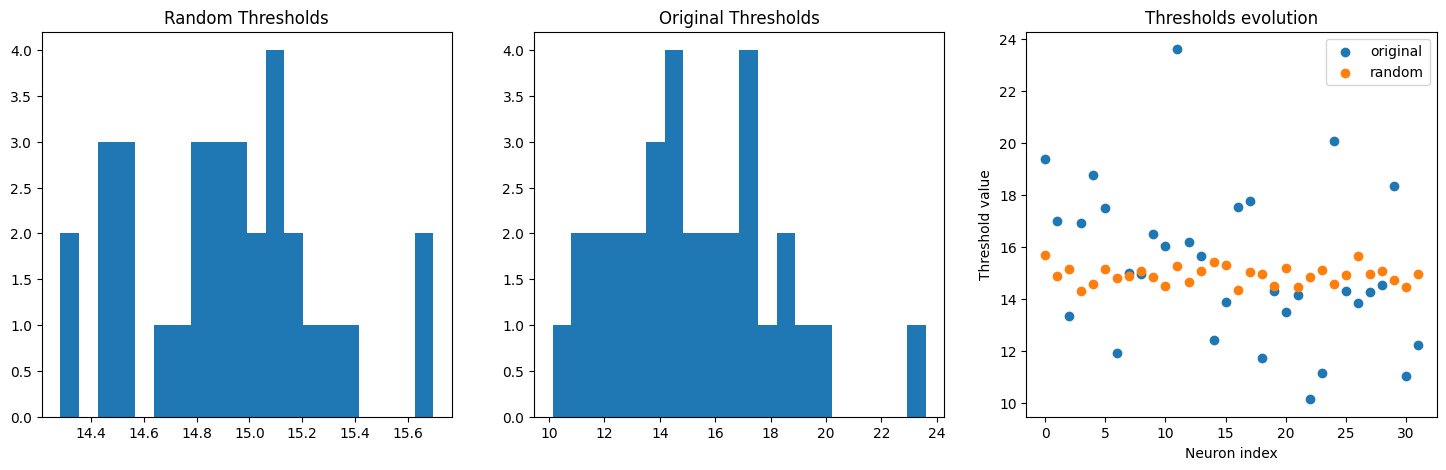


TEST 5

Train metrics:
Accuracy: 0.61
Precision: 0.66
Recall: 0.61
F1 Score: 0.59

Validation metrics:
Accuracy: 0.61
Precision: 0.70
Recall: 0.61
F1 Score: 0.60


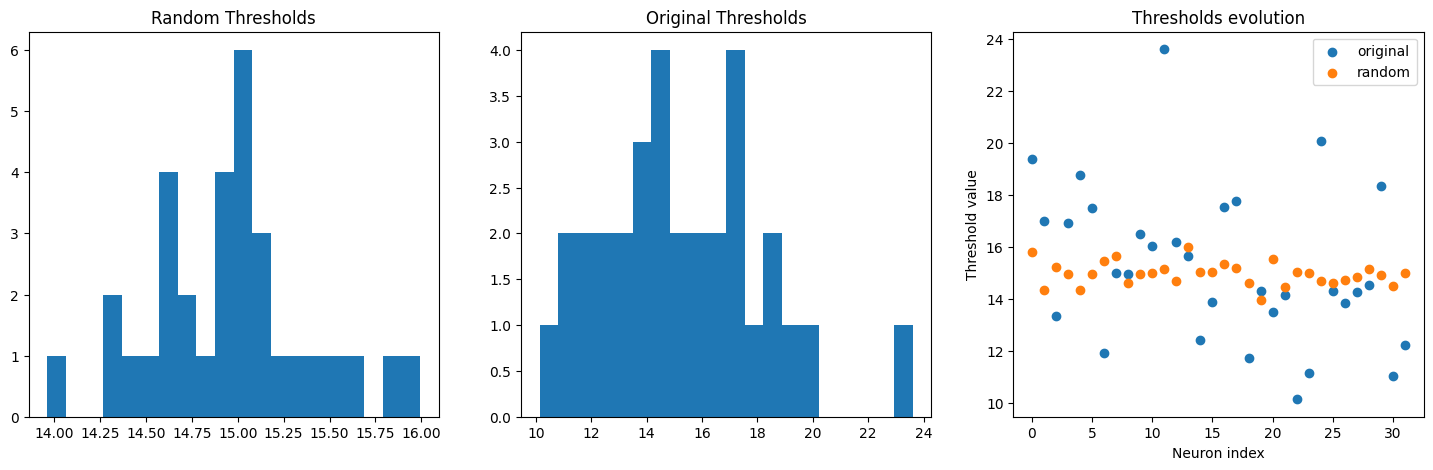


TEST 6

Train metrics:
Accuracy: 0.62
Precision: 0.67
Recall: 0.62
F1 Score: 0.61

Validation metrics:
Accuracy: 0.58
Precision: 0.67
Recall: 0.58
F1 Score: 0.58


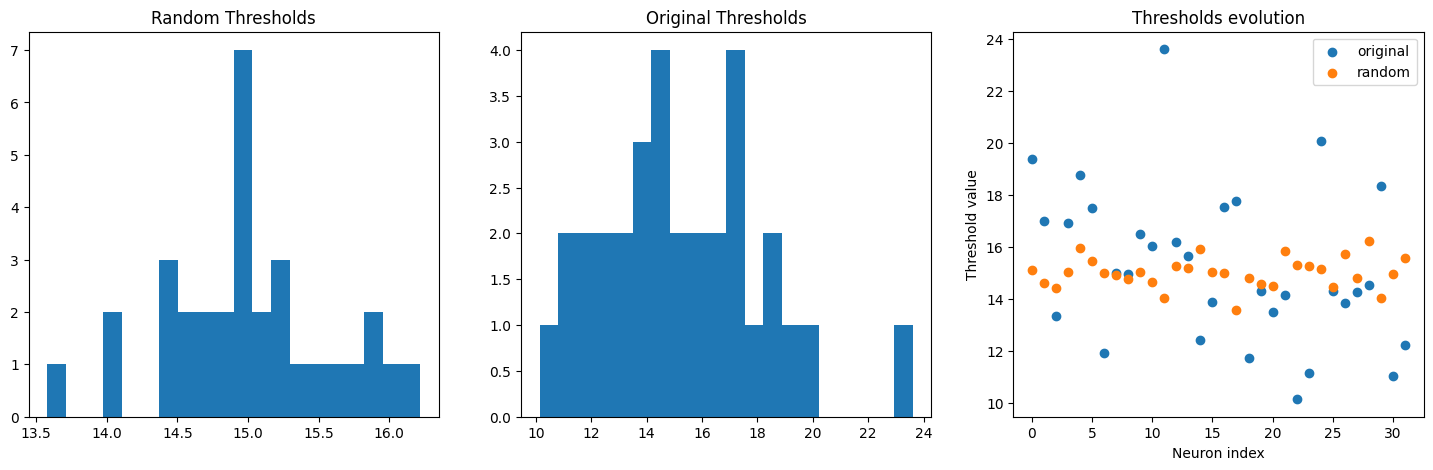


TEST 7

Train metrics:
Accuracy: 0.62
Precision: 0.67
Recall: 0.62
F1 Score: 0.60

Validation metrics:
Accuracy: 0.60
Precision: 0.67
Recall: 0.60
F1 Score: 0.59


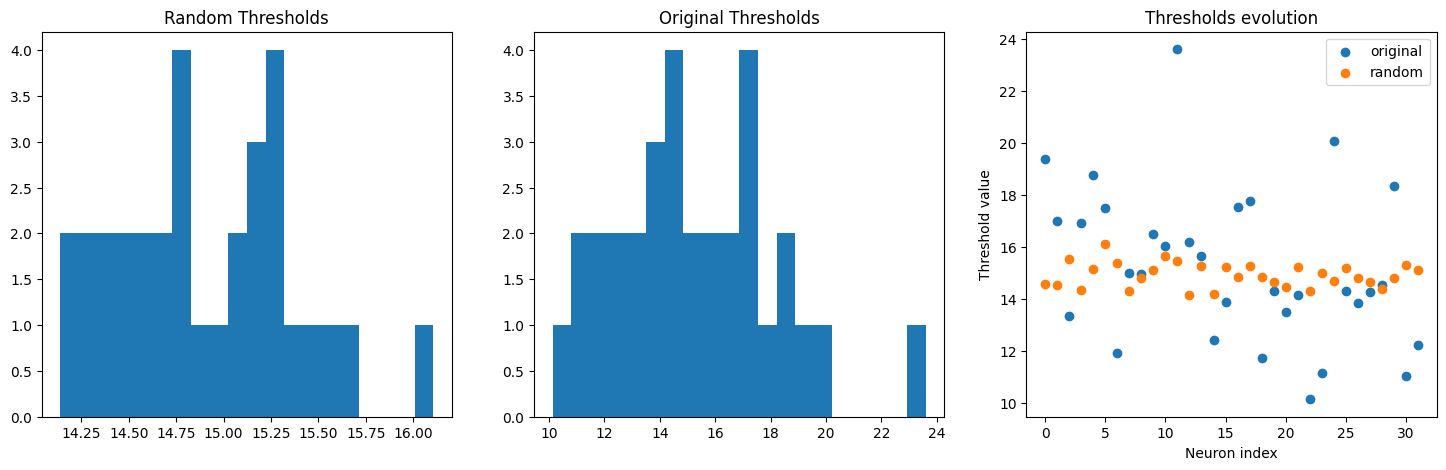


TEST 8

Train metrics:
Accuracy: 0.62
Precision: 0.66
Recall: 0.62
F1 Score: 0.60

Validation metrics:
Accuracy: 0.59
Precision: 0.66
Recall: 0.59
F1 Score: 0.57


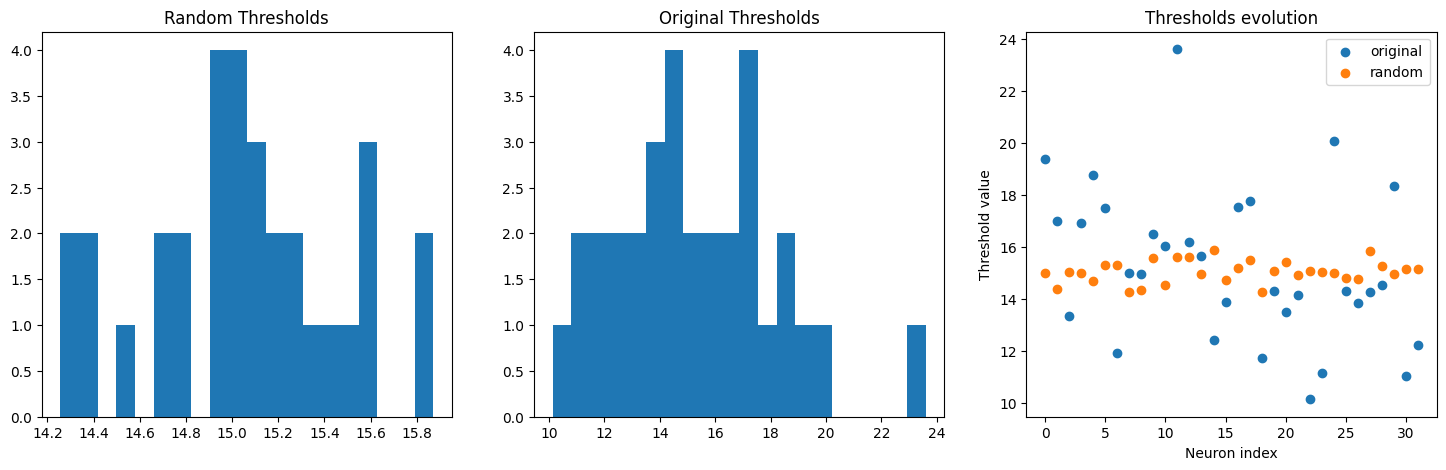


TEST 9

Train metrics:
Accuracy: 0.62
Precision: 0.66
Recall: 0.62
F1 Score: 0.60

Validation metrics:
Accuracy: 0.61
Precision: 0.69
Recall: 0.61
F1 Score: 0.59


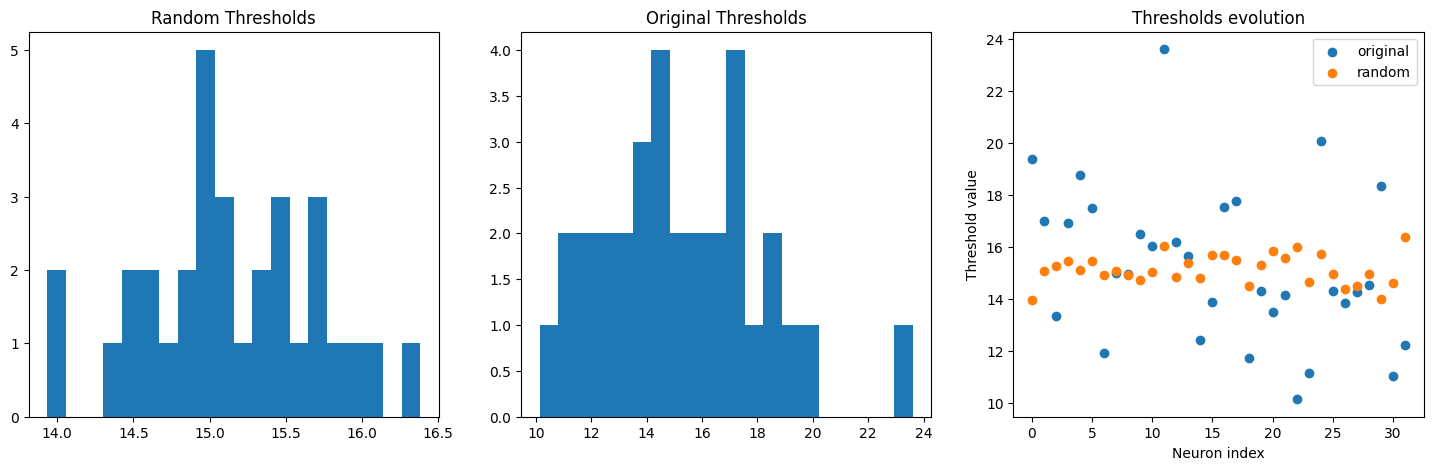

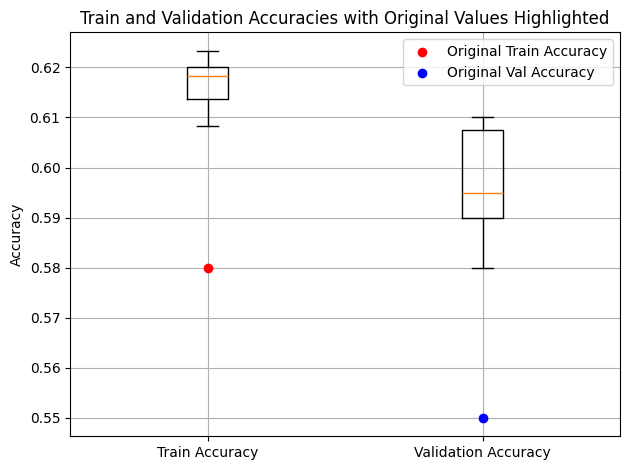

In [43]:
train_accuracies, val_accuracies = simulate_random_thresholds(lambda shape: torch.normal(mean=15, std=0.5, size=shape), 10)
plot_train_accuracies_vs_val_accuracies(train_accuracies, val_accuracies, 0.58, 0.55)

## Variate the most useful threshold, fix the rest

In [15]:
def simulate_range_threshold_for_weight(weight_idx: int, interval: np.ndarray = np.arange(13, 16, 0.1)):
    train_accuracies = []
    val_accuracies = []

    for threshold in interval:
        model_threshold = load_model(f"../checkpoints/{model_checkpoint_name}.pkl")
        model_threshold.thresholds[weight_idx] = threshold

        metrics = eval_snn(model_threshold, train=True, visualize=False, verbose=False)
        train_accuracy, val_accuracy = metrics[0][0], metrics[1][0]
        print(f"Accuracies for threshold({threshold}): train({train_accuracy}), val({val_accuracy})")
        train_accuracies.append(metrics[0][0])
        val_accuracies.append(metrics[1][0])

    return train_accuracies, val_accuracies

In [27]:
train_accuracies_3, val_accuracies_3 = simulate_range_threshold_for_weight(11, interval=np.arange(9.0, 11.0, 0.1))

Accuracies for threshold(9.0): train(0.6066666666666667), val(0.55)
Accuracies for threshold(9.1): train(0.6066666666666667), val(0.55)
Accuracies for threshold(9.2): train(0.6083333333333333), val(0.56)
Accuracies for threshold(9.299999999999999): train(0.6066666666666667), val(0.55)
Accuracies for threshold(9.399999999999999): train(0.6083333333333333), val(0.56)
Accuracies for threshold(9.499999999999998): train(0.6066666666666667), val(0.56)
Accuracies for threshold(9.599999999999998): train(0.6066666666666667), val(0.55)
Accuracies for threshold(9.699999999999998): train(0.6083333333333333), val(0.55)
Accuracies for threshold(9.799999999999997): train(0.6083333333333333), val(0.55)
Accuracies for threshold(9.899999999999997): train(0.605), val(0.55)
Accuracies for threshold(9.999999999999996): train(0.6066666666666667), val(0.54)
Accuracies for threshold(10.099999999999996): train(0.6083333333333333), val(0.54)
Accuracies for threshold(10.199999999999996): train(0.61), val(0.54)
A

In [28]:
train_accuracies = [*train_accuracies_3, *train_accuracies]
val_accuracies = [*val_accuracies_3, *val_accuracies]

tensor(23.6019)


/var/folders/s2/81dpl6dd6xq1m2_npzc7ngcw0000gp/T/ipykernel_82047/1921388793.py:4: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.plot(model_test.thresholds[11] * np.ones(10), np.arange(0.52,0.62,0.01), '--', label="Original Threshold")


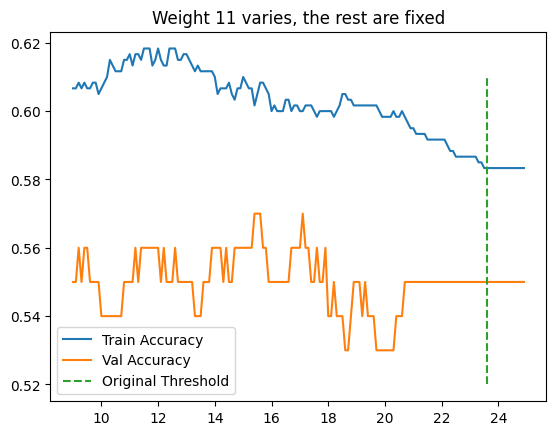

In [41]:
print(model_test.thresholds[11])
plt.plot(np.arange(9.0, 25.0, 0.1), train_accuracies, label="Train Accuracy")
plt.plot(np.arange(9.0, 25.0, 0.1), val_accuracies, label="Val Accuracy")
plt.plot(model_test.thresholds[11] * np.ones(10), np.arange(0.52,0.62,0.01), '--', label="Original Threshold")
plt.legend()
plt.title("Weight 11 varies, the rest are fixed")
plt.show()

## Training test

In [5]:
import tqdm
import torch.nn as nn
import torch.optim as optim

num_classes = 10
model_test.thresholds = nn.Parameter(model_test.thresholds)

In [6]:
def train_classifier(
    dataloader: Dataloader,
    spiking_model: IntegrateAndFireOptimizedLayer,
    classif_head: nn.Module,
    num_epochs: int = 20,
    batch_size: int = 1,
    optimizer=None,
):
    losses = []
    loss_fn = nn.CrossEntropyLoss()
    classif_head.train()
    pbar = tqdm.tqdm(range(0, num_epochs))

    batch = 0
    logits = torch.zeros((batch_size, num_classes))
    labels = torch.zeros((batch_size,)).long()

    for _ in pbar:
        for (spikes, label, _) in dataloader.iterate(batch_size=1, shuffle=True):
            spike_time_proxy = torch.zeros(spiking_model.num_outputs)
            for incoming_spikes, current_time, dt in iterate_spikes(spikes, shape=(max_z, max_x, max_y)):
                surrogate_spikes = spiking_model.forward(incoming_spikes.flatten(), current_time=current_time, dt=dt)
                weight = 1.0 - current_time
                spike_time_proxy += surrogate_spikes * weight
                if torch.any(surrogate_spikes > 0):
                    break
            spiking_model.reset()

            logits[batch] = classif_head(spike_time_proxy)
            labels[batch] = label
            batch += 1

            if batch % batch_size == 0:
                loss = loss_fn(logits, labels)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                pbar.set_postfix(loss=loss.item())
                losses.append(loss.item())
                batch = 0
                logits = torch.zeros((batch_size, num_classes))
                labels = torch.zeros((batch_size,)).long()

    plt.plot(losses)
    plt.title("Loss")
    plt.xlabel("Step")
    plt.ylabel("Loss")
    plt.show()

## Train only classif head

100%|██████████| 50/50 [21:46<00:00, 26.12s/it, loss=2.24]


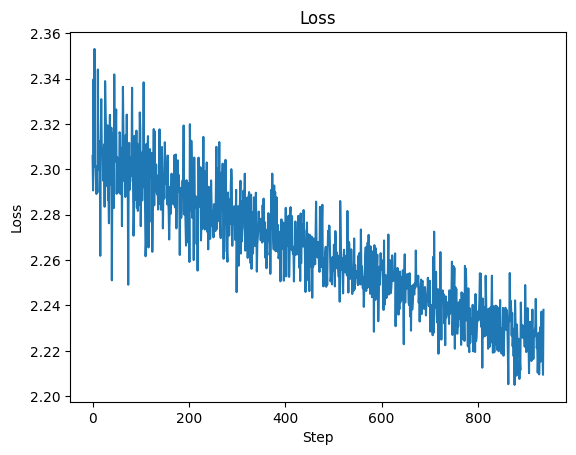

In [21]:
classif_head = nn.Linear(num_outputs, num_classes)

optimizer = optim.Adam(classif_head.parameters(), lr=0.001)
train_classifier(dataloader, model_test, classif_head, num_epochs=50, batch_size=32, optimizer=optimizer)

Train metrics:
Accuracy: 0.70
Precision: 0.70
Recall: 0.71
F1 Score: 0.68


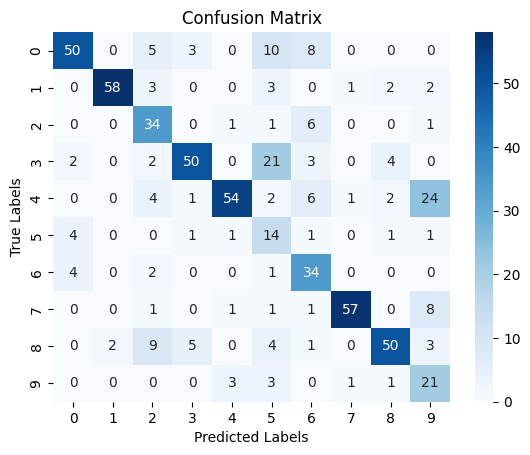

Validation metrics:
Accuracy: 0.70
Precision: 0.70
Recall: 0.71
F1 Score: 0.67


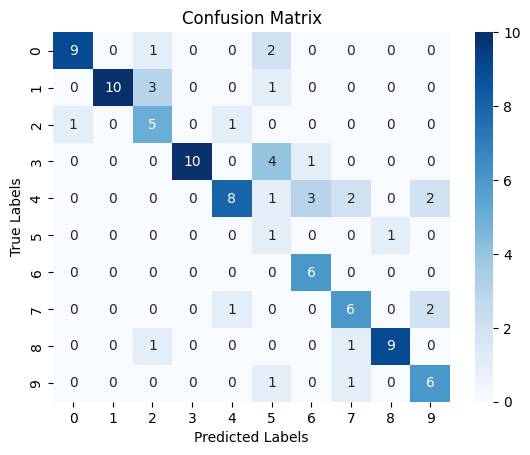

In [24]:
evaluator = SpikingClassifierEvaluator(model_test, dataloader, test_dataloader, shape=(max_z, max_x, max_y))
evaluator.eval_classifier(classifier=classif_head)

## Tune thresholds directly

100%|██████████| 50/50 [34:45<00:00, 41.71s/it, loss=2.23]


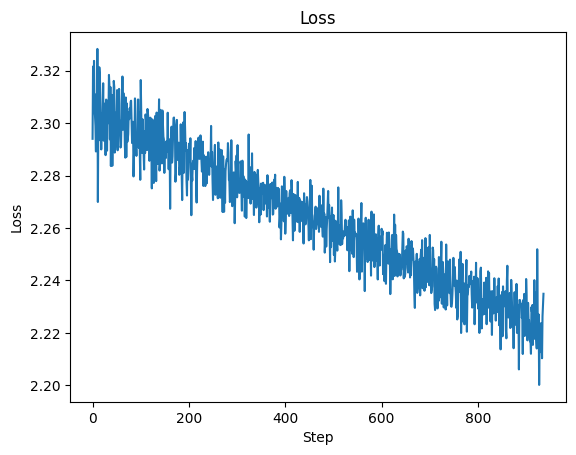

In [7]:
classif_head = nn.Linear(num_outputs, num_classes)
optimizer = optim.Adam([*classif_head.parameters(), model_test.thresholds], lr=0.001) # TODO: change to 0.01 for next experiments
train_classifier(dataloader, model_test, classif_head, num_epochs=50, batch_size=32, optimizer=optimizer)

(array([1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 3., 0.,
        0., 0., 0., 0., 0., 0., 2., 1., 3., 3., 2., 0., 2., 0., 2., 1., 1.,
        0., 2., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 1.]),
 array([ 33.3723259 ,  34.84896469,  36.32560349,  37.80223846,
         39.27887726,  40.75551605,  42.23215485,  43.70879364,
         45.18543243,  46.66207123,  48.13871002,  49.61534882,
         51.0919838 ,  52.56862259,  54.04526138,  55.52189636,
         56.99853516,  58.47517395,  59.95181274,  61.42845154,
         62.90509033,  64.38172913,  65.85836792,  67.33500671,
         68.81164551,  70.2882843 ,  71.7649231 ,  73.24156189,
         74.71820068,  76.19483185,  77.67147064,  79.14810944,
         80.62474823,  82.10138702,  83.57802582,  85.05466461,
         86.53129578,  88.00793457,  89.48457336,  90.96121216,
         92.43785095,  93.91448975,  95.39112854,  96.86776733,
         98.34440613,  99.82104492, 101.29768372, 102.77432251,
      

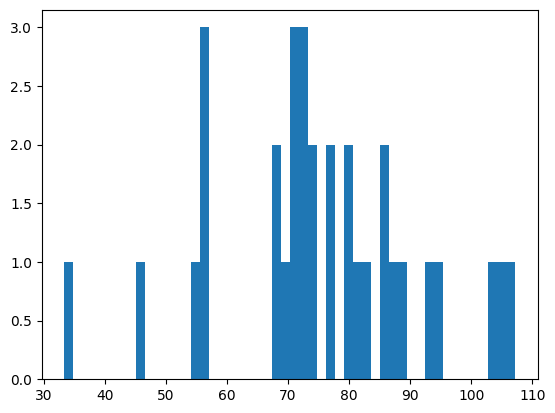

In [8]:
plt.hist(model_test.thresholds.detach().numpy(), bins=50)

Train metrics:
Accuracy: 0.72
Precision: 0.72
Recall: 0.73
F1 Score: 0.70


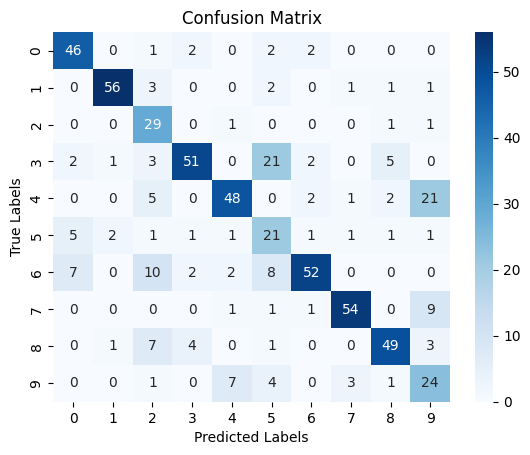

Validation metrics:
Accuracy: 0.68
Precision: 0.68
Recall: 0.69
F1 Score: 0.66


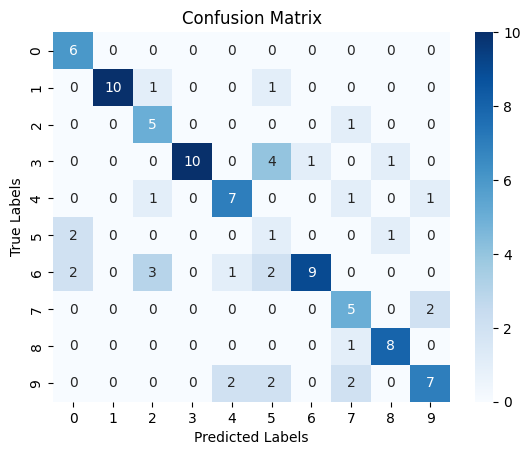

In [9]:
evaluator = SpikingClassifierEvaluator(model_test, dataloader, test_dataloader, shape=(max_z, max_x, max_y))
evaluator.eval_classifier(classifier=classif_head)

Train metrics:
Accuracy: 0.69
Precision: 0.69
Recall: 0.69
F1 Score: 0.68


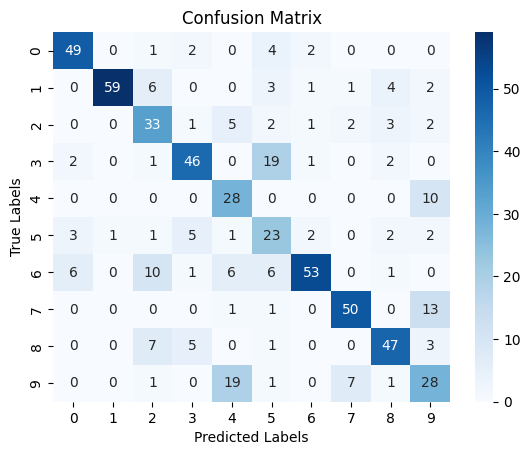

Validation metrics:
Accuracy: 0.64
Precision: 0.64
Recall: 0.66
F1 Score: 0.63


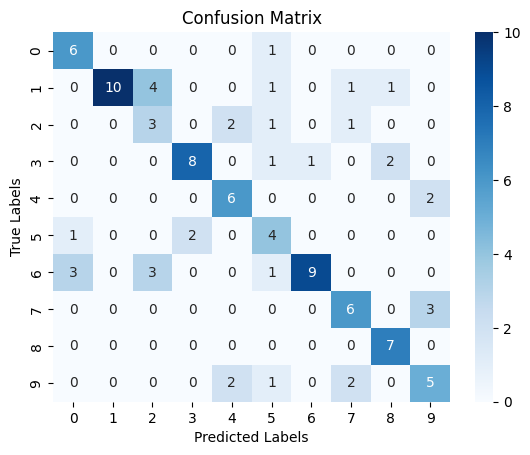

In [10]:
evaluator.eval_classifier(train=True)

In [11]:
save_model(model_test, f"../checkpoints/{model_checkpoint_name}_tuned_directly_v2.pkl")

(array([1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 3., 0.,
        0., 0., 0., 0., 0., 0., 2., 1., 3., 3., 2., 0., 2., 1., 0., 2., 1.,
        0., 2., 1., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 1., 1.]),
 array([ 33.25613022,  34.73207474,  36.20801544,  37.68395996,
         39.15990448,  40.635849  ,  42.1117897 ,  43.58773422,
         45.06367493,  46.53961945,  48.01556396,  49.49150848,
         50.96744919,  52.44339371,  53.91933441,  55.39527893,
         56.87122345,  58.34716797,  59.82311249,  61.29905319,
         62.77499771,  64.25093842,  65.72688293,  67.20282745,
         68.67877197,  70.15470886,  71.63066101,  73.1065979 ,
         74.58254242,  76.05848694,  77.53443146,  79.01037598,
         80.48631287,  81.96226501,  83.4382019 ,  84.91414642,
         86.39009094,  87.86602783,  89.34197998,  90.81791687,
         92.29386902,  93.76980591,  95.24575043,  96.72169495,
         98.19763184,  99.67358398, 101.14952087, 102.62547302,
      

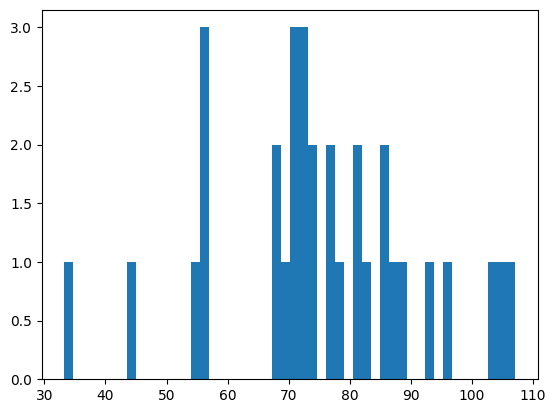

In [34]:
plt.hist(model_test.thresholds.detach().numpy(), bins=50)

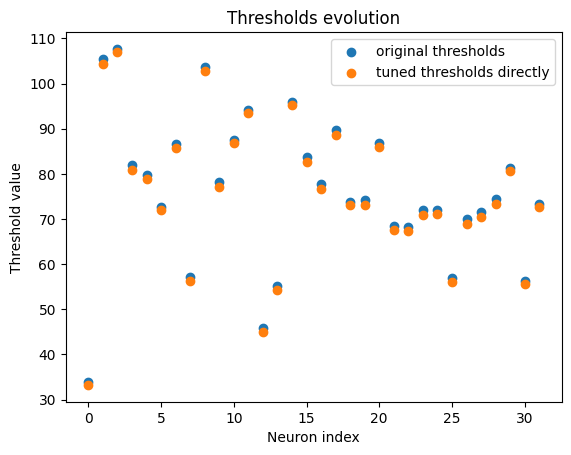

MSE: 0.88280797
Bigger thresholds in model2: 32 / 32
Mean before 76.12251 vs after 75.24849


In [39]:
import numpy as np

model1_thresholds = (
    load_model(f"../checkpoints/{model_checkpoint_name}.pkl")
        .thresholds
        .detach()
        .numpy()
)
model2_thresholds = (
    load_model(f"../checkpoints/{model_checkpoint_name}_tuned_directly.pkl")
        .thresholds
        .detach()
        .numpy()
)

plot_thresholds((model1_thresholds, 'original thresholds'), (model2_thresholds, 'tuned thresholds directly'))

diff = model1_thresholds - model2_thresholds
mse = np.sqrt(np.mean(diff ** 2))
print("MSE:", mse)

print("Bigger thresholds in model2:", np.sum(diff > 0), "/", len(diff))
print(
    "Mean before",
    np.mean(model1_thresholds),
    "vs after",
    np.mean(model2_thresholds),
)

## Tuned from random

(array([1., 0., 0., 0., 0., 0., 3., 1., 0., 0., 1., 2., 2., 0., 1., 0., 1.,
        0., 2., 1., 0., 0., 1., 0., 1., 0., 1., 0., 0., 1., 0., 0., 2., 1.,
        0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 2., 1., 1., 1., 1., 1.]),
 array([  1.60013437,   4.49218035,   7.38422632,  10.27627182,
         13.16831779,  16.06036377,  18.95240974,  21.84445572,
         24.73650169,  27.62854767,  30.52059364,  33.41263962,
         36.3046875 ,  39.19673157,  42.08877945,  44.98082733,
         47.8728714 ,  50.76491547,  53.65696335,  56.54901123,
         59.4410553 ,  62.33309937,  65.22514343,  68.11719513,
         71.0092392 ,  73.90128326,  76.79332733,  79.68537903,
         82.5774231 ,  85.46946716,  88.36151886,  91.25356293,
         94.14560699,  97.03765106,  99.92969513, 102.82174683,
        105.71379089, 108.60583496, 111.49788666, 114.38993073,
        117.28197479, 120.17401886, 123.06606293, 125.95811462,
        128.85015869, 131.74220276, 134.63424683, 137.52629089,
      

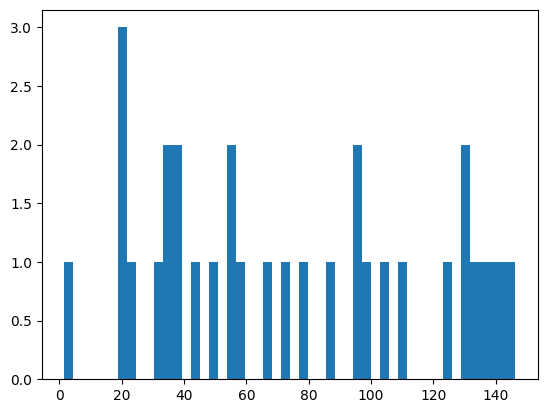

In [41]:
model_test.thresholds = nn.Parameter(torch.rand(model_test.thresholds.shape) * 150)
plt.hist(model_test.thresholds.detach().numpy(), bins=50)

100%|██████████| 50/50 [05:58<00:00,  7.17s/it, loss=2.3] 


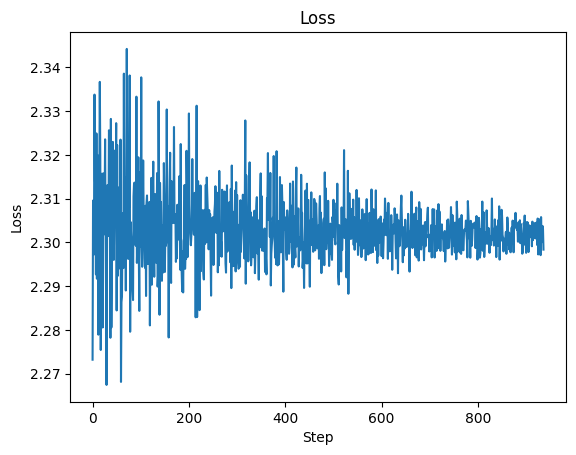

In [42]:
classif_head = nn.Linear(num_outputs, num_classes)
optimizer = optim.Adam([*classif_head.parameters(), model_test.thresholds], lr=0.001)
train_classifier(dataloader, model_test, classif_head, num_epochs=50, batch_size=32, optimizer=optimizer)

Train metrics:
Accuracy: 0.14
Precision: 0.14
Recall: 0.04
F1 Score: 0.06


/Users/Razvan/CodeUni/dummy-snn/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


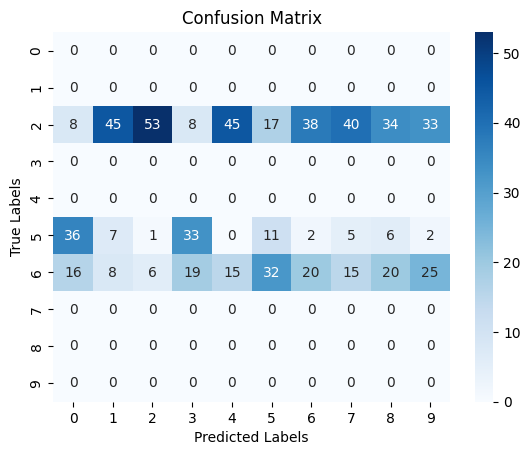

Validation metrics:
Accuracy: 0.14
Precision: 0.14
Recall: 0.04
F1 Score: 0.06


/Users/Razvan/CodeUni/dummy-snn/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


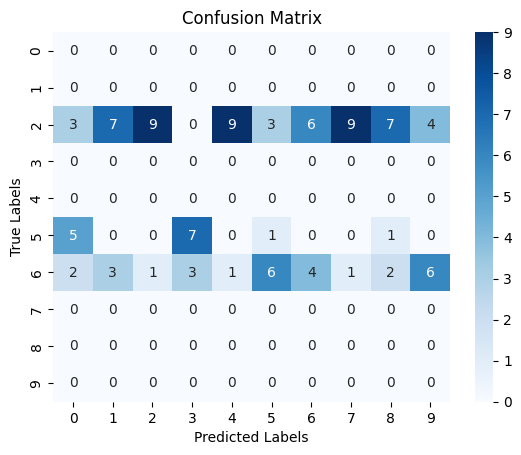

In [47]:
evaluator = SpikingClassifierEvaluator(model_test, dataloader, test_dataloader, shape=(max_z, max_x, max_y))
evaluator.eval_classifier(classifier=classif_head)

Train metrics:
Accuracy: 0.69
Precision: 0.68
Recall: 0.70
F1 Score: 0.67


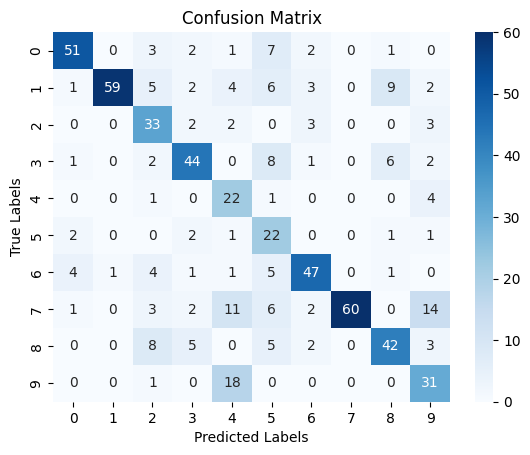

Validation metrics:
Accuracy: 0.69
Precision: 0.69
Recall: 0.72
F1 Score: 0.68


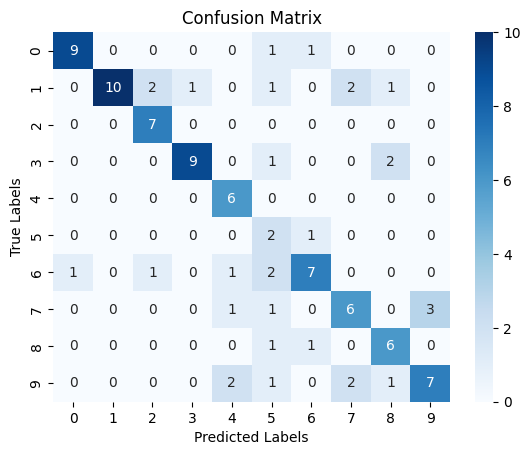

In [48]:
evaluator.eval_classifier(train=True)

(array([1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 0., 3., 0., 2., 0., 1., 1.,
        3., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 2., 2., 0., 0., 0., 0.,
        1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 2., 0., 1.]),
 array([ 15.4173193 ,  18.10010529,  20.78289032,  23.46567535,
         26.14846039,  28.83124542,  31.51403046,  34.19681549,
         36.87960052,  39.56238556,  42.24517059,  44.92795563,
         47.61074066,  50.2935257 ,  52.97631073,  55.65909576,
         58.3418808 ,  61.02466583,  63.70745087,  66.3902359 ,
         69.07302094,  71.75580597,  74.438591  ,  77.12137604,
         79.80416107,  82.48694611,  85.16973114,  87.85251617,
         90.53530121,  93.21808624,  95.90087128,  98.58365631,
        101.26644135, 103.94922638, 106.63201141, 109.31479645,
        111.99758148, 114.68036652, 117.36315155, 120.04593658,
        122.72872162, 125.41150665, 128.09428406, 130.77706909,
        133.45985413, 136.14263916, 138.82542419, 141.50820923,
      

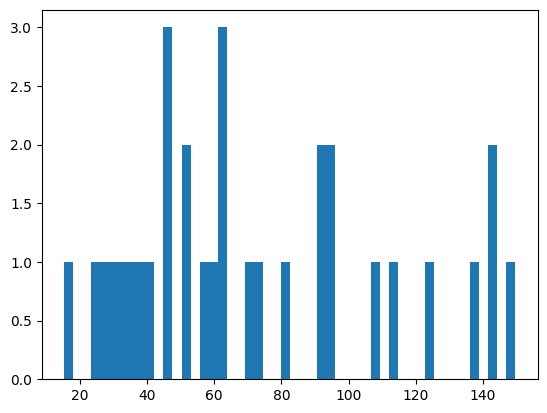

In [49]:
# model_test.thresholds = nn.Parameter(torch.rand(model_test.thresholds.shape) * 150)
plt.hist(model_test.thresholds.detach().numpy(), bins=50)

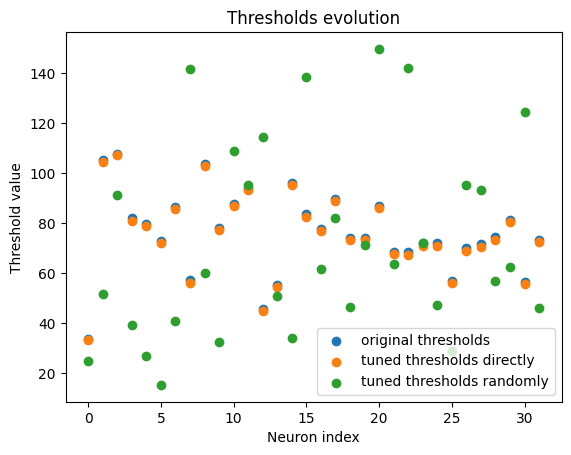

In [50]:
plot_thresholds(
    (model1_thresholds, 'original thresholds'),
    (model2_thresholds, 'tuned thresholds directly'),
    (model_test.thresholds.detach().numpy(), 'tuned thresholds randomly'),
)

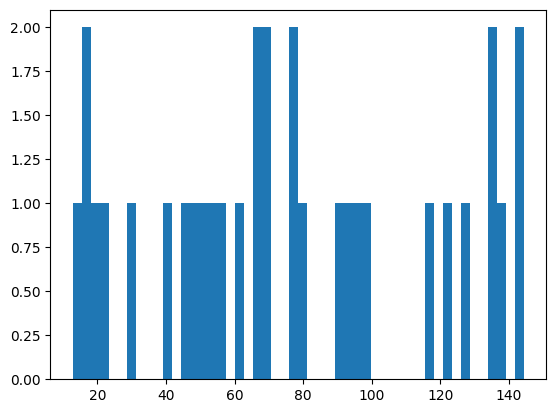

Train metrics:
Accuracy: 0.66
Precision: 0.66
Recall: 0.68
F1 Score: 0.63


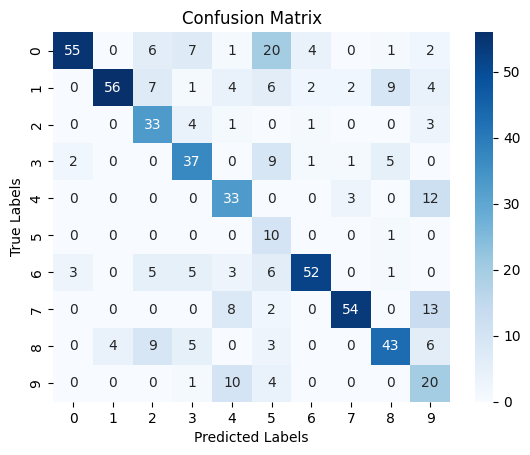

Validation metrics:
Accuracy: 0.71
Precision: 0.71
Recall: 0.73
F1 Score: 0.69


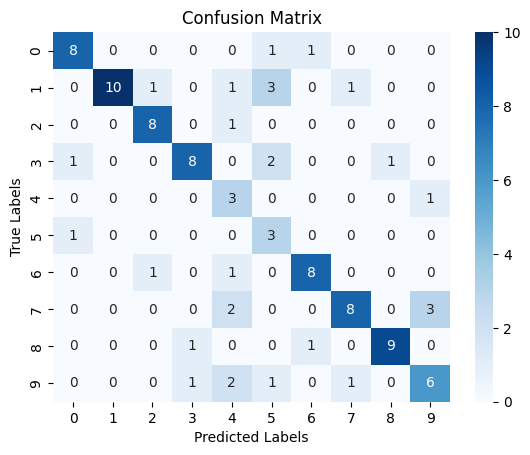

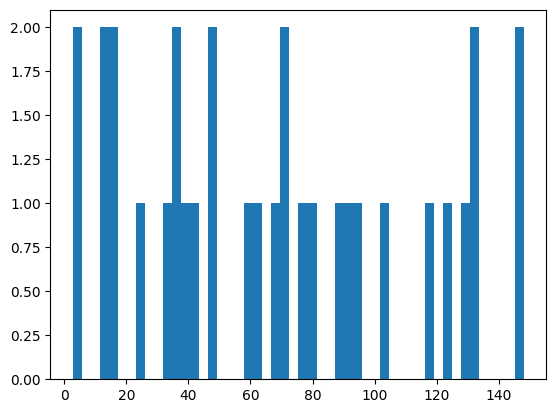

Train metrics:
Accuracy: 0.68
Precision: 0.68
Recall: 0.70
F1 Score: 0.66


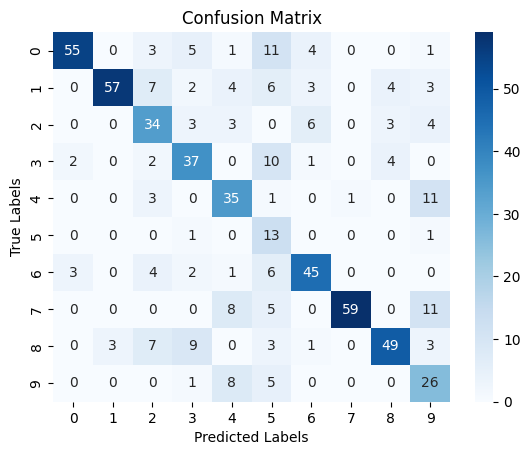

Validation metrics:
Accuracy: 0.65
Precision: 0.65
Recall: 0.68
F1 Score: 0.63


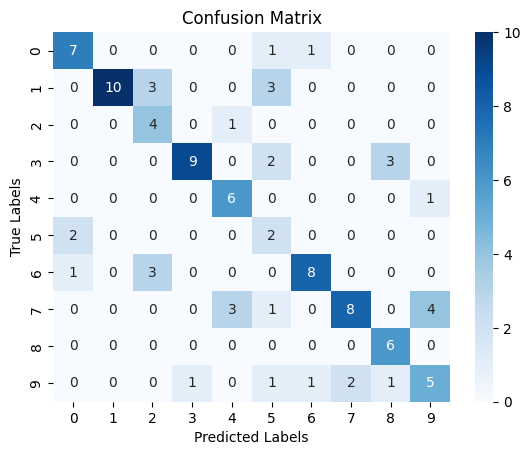

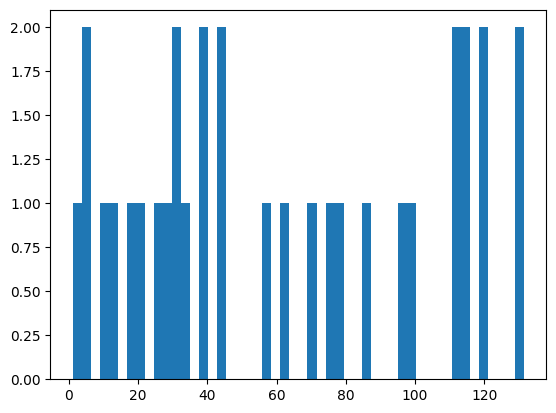

Train metrics:
Accuracy: 0.67
Precision: 0.67
Recall: 0.68
F1 Score: 0.66


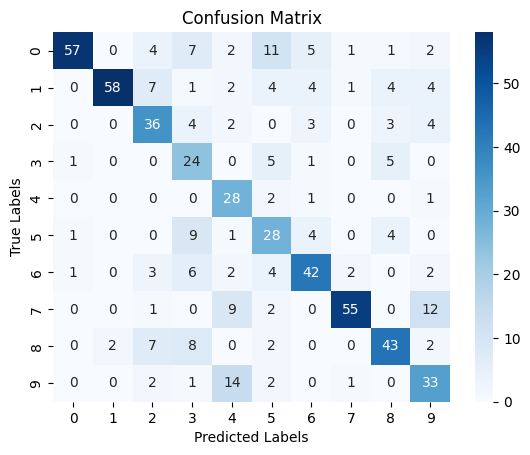

Validation metrics:
Accuracy: 0.61
Precision: 0.61
Recall: 0.66
F1 Score: 0.59


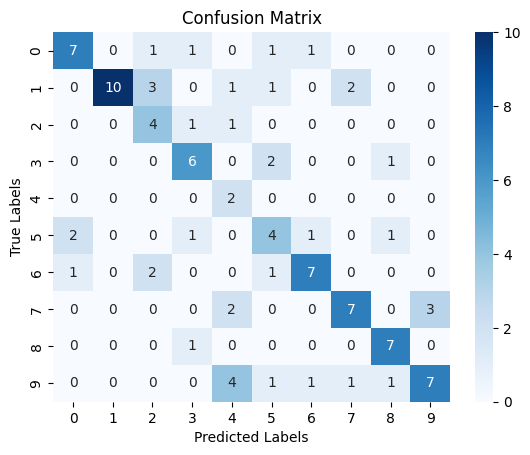

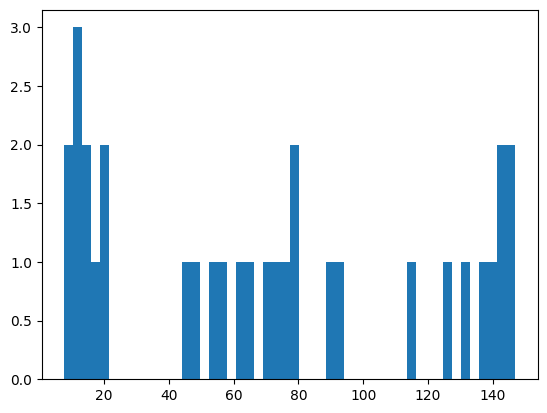

Train metrics:
Accuracy: 0.65
Precision: 0.65
Recall: 0.66
F1 Score: 0.61


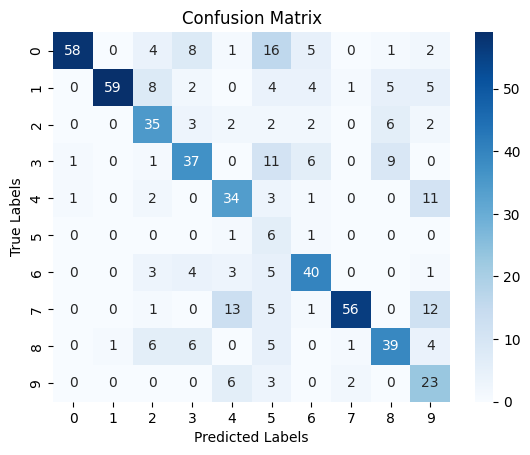

Validation metrics:
Accuracy: 0.63
Precision: 0.63
Recall: 0.60
F1 Score: 0.59


/Users/Razvan/CodeUni/dummy-snn/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


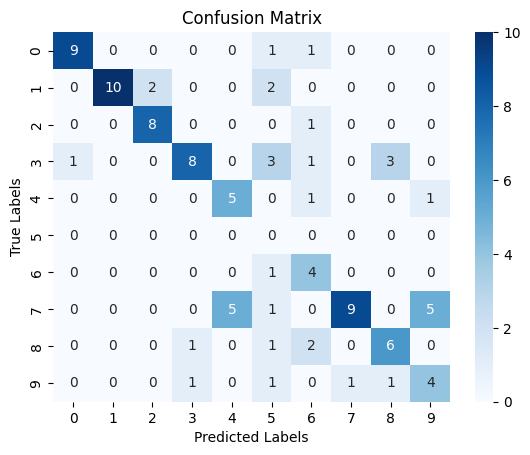

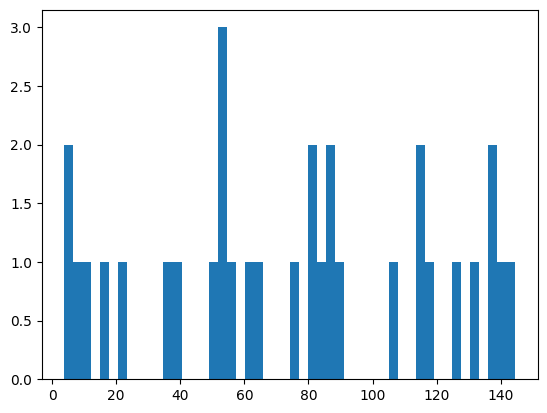

Train metrics:
Accuracy: 0.63
Precision: 0.63
Recall: 0.64
F1 Score: 0.60


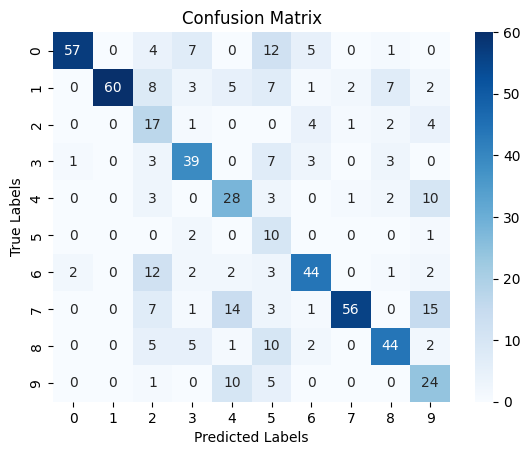

Validation metrics:
Accuracy: 0.54
Precision: 0.54
Recall: 0.52
F1 Score: 0.49


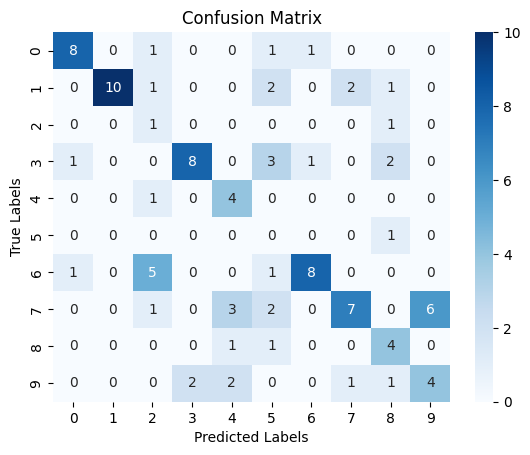

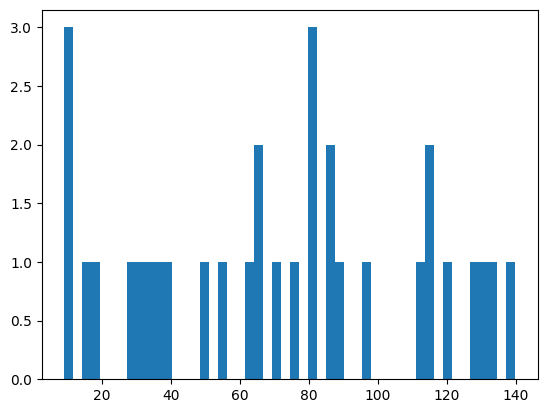

Train metrics:
Accuracy: 0.66
Precision: 0.66
Recall: 0.67
F1 Score: 0.64


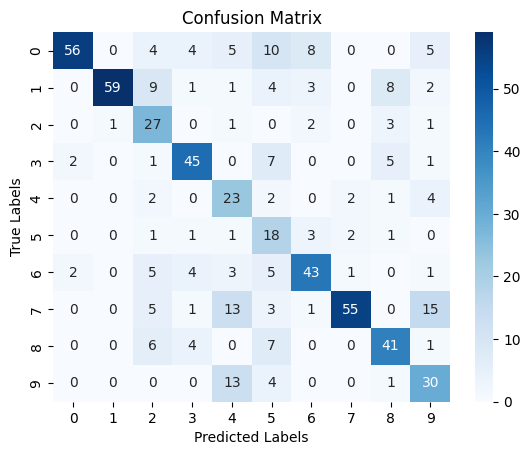

Validation metrics:
Accuracy: 0.64
Precision: 0.64
Recall: 0.64
F1 Score: 0.61


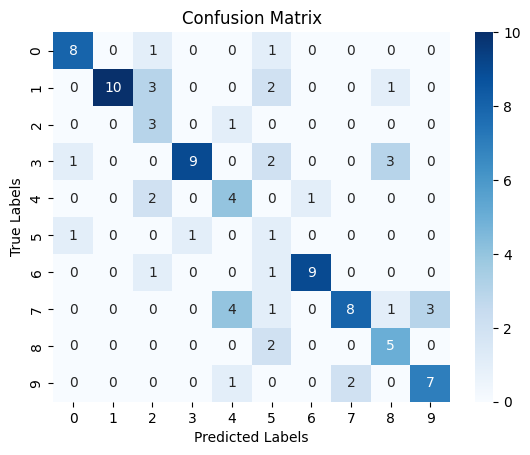

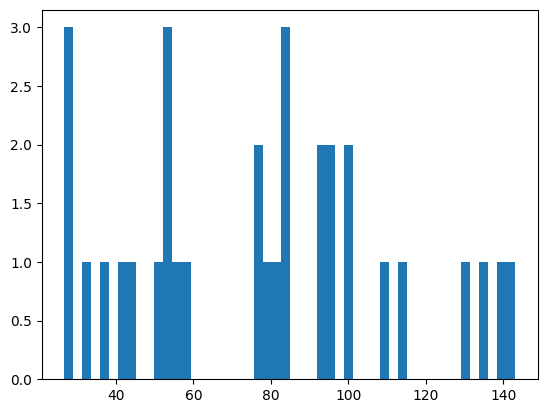

Train metrics:
Accuracy: 0.66
Precision: 0.66
Recall: 0.70
F1 Score: 0.64


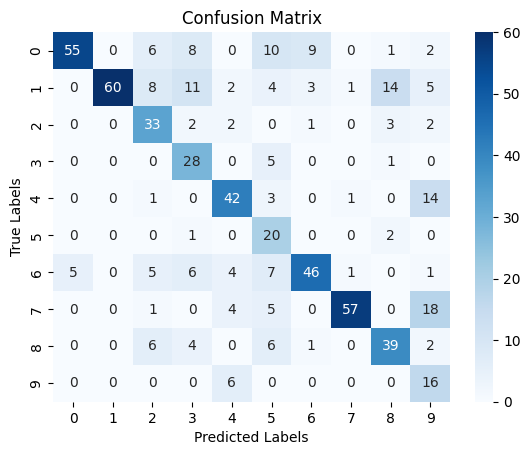

Validation metrics:
Accuracy: 0.63
Precision: 0.63
Recall: 0.66
F1 Score: 0.60


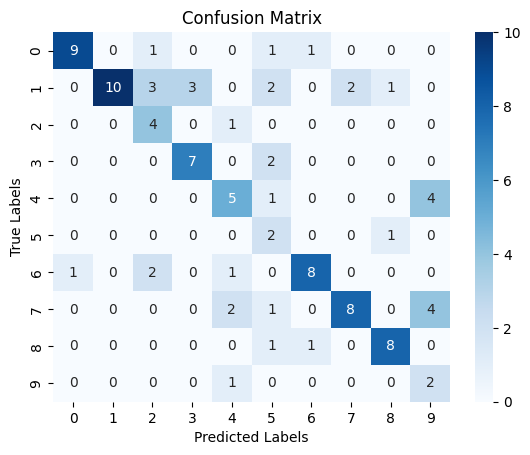

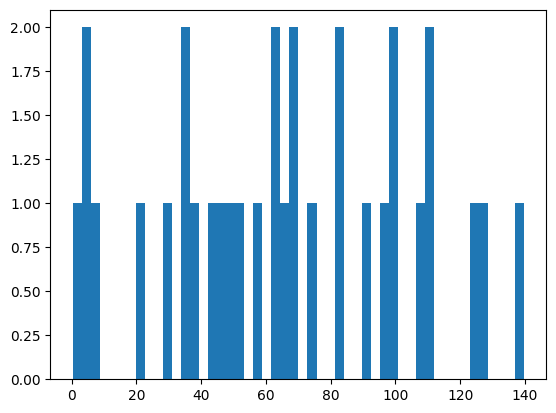

Train metrics:
Accuracy: 0.67
Precision: 0.67
Recall: 0.67
F1 Score: 0.64


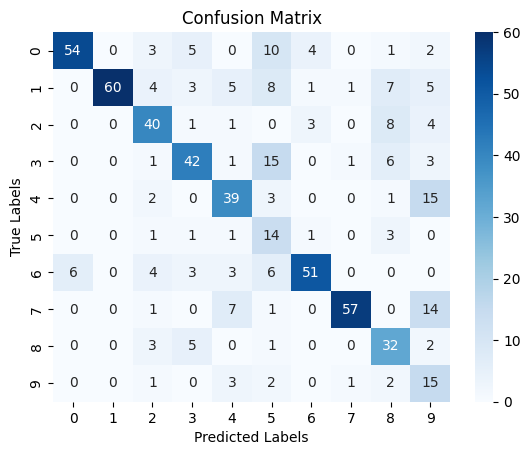

Validation metrics:
Accuracy: 0.62
Precision: 0.62
Recall: 0.63
F1 Score: 0.60


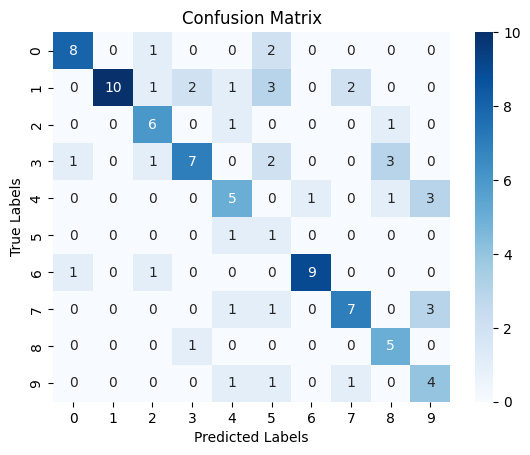

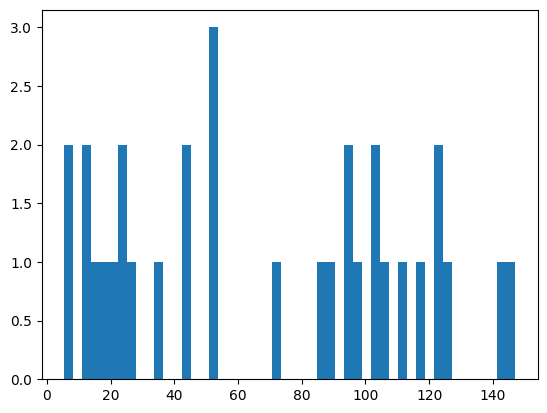

Train metrics:
Accuracy: 0.65
Precision: 0.65
Recall: 0.66
F1 Score: 0.62


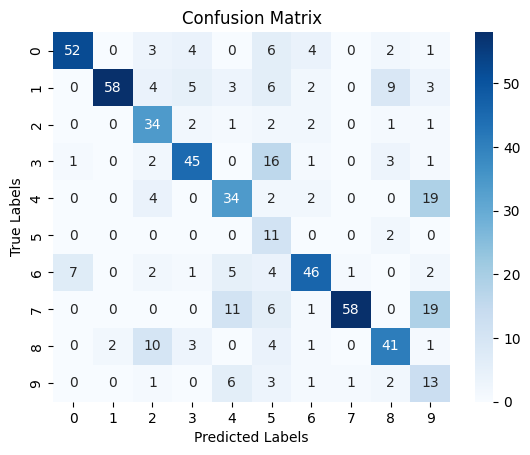

Validation metrics:
Accuracy: 0.66
Precision: 0.66
Recall: 0.68
F1 Score: 0.64


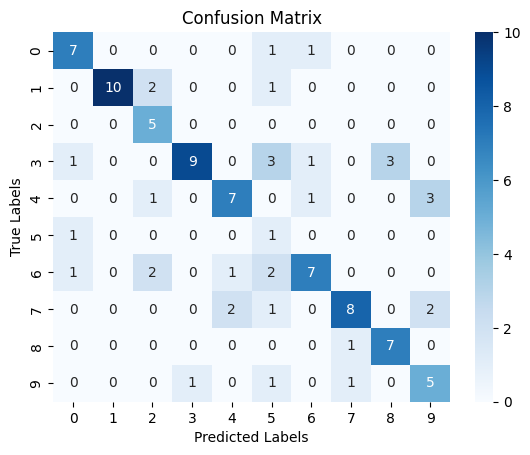

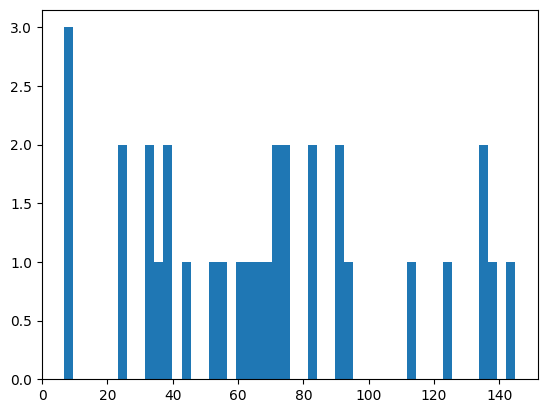

Train metrics:
Accuracy: 0.67
Precision: 0.67
Recall: 0.67
F1 Score: 0.64


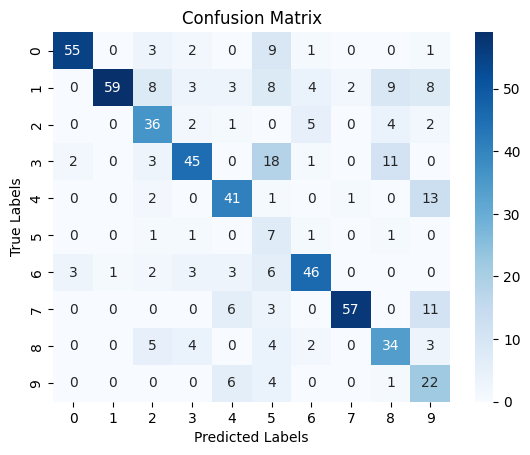

Validation metrics:
Accuracy: 0.66
Precision: 0.66
Recall: 0.67
F1 Score: 0.64


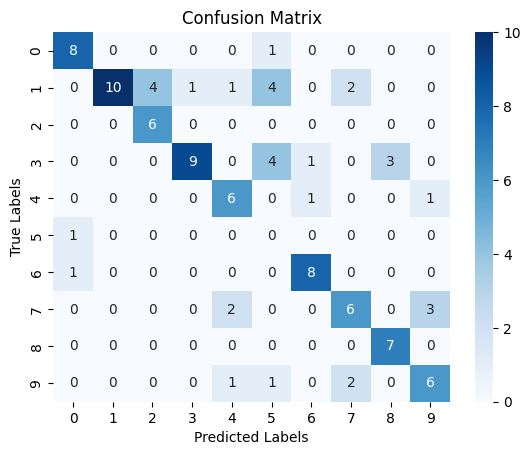

In [18]:
for i in range(10):
    model_test = load_model(f"../checkpoints/{model_checkpoint_name}.pkl")
    model_test.thresholds = nn.Parameter(torch.rand(model_test.thresholds.shape) * 150)
    plt.hist(model_test.thresholds.detach().numpy(), bins=50)
    plt.show()
    evaluator = SpikingClassifierEvaluator(model_test, dataloader, test_dataloader, shape=(max_z, max_x, max_y))
    evaluator.eval_classifier(train=True)